# Learning Through Target Bursts (LTTB)

### This code below is to set the structure of the code for Pyramidal Neuron - Larkum style

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload
from tqdm import trange
import random
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import json
import glob
import re
from scipy.ndimage import gaussian_filter1d

import lttb_contesto_both as lttb_module
#from lttb_contesto_sopra import LTTB

In [16]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [26]:
"""
N, I, O, T = 1000, 50, 3, 1000
Ne = 800
Ni = 200

#shape = (N, I, O, T)

dt = .001
tau_m = 20. * dt
tau_s = 2. * dt
tau_ro = 10. * dt
tau_star = 20. * dt
tau_W = 200 * dt

# std of J's used to project context - it used to be 20
sigma_apical_cont = 20
sigma_basal_cont = 0
sigma_targ = 30 # 10**1.5
sigma_in = 12.




du = 0.1
alpha = .005
alpha_rout = .01
Vo = - 4
h = - 1
s_inh = 20

sigma_Jrec = 0.
sigma_wrec = 0.
sigma_Jout = 0.1

n_contexts = 1

# Here we build the dictionary of the simulation parameters
par = {'N' : N, 'Ni' : Ni, 'Ne' : Ne, 'T' : T, 'I' : I, 'O' : O,
       'dt' : dt, 'tau_m' : tau_m, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'tau_star' : tau_star,'tau_W' : tau_W,
       'du' : du, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
       'sigma_Jrec' : sigma_Jrec,'sigma_wrec' : sigma_wrec, 'sigma_Jout' : sigma_Jout,  'n_contexts' : n_contexts,
       'alpha' : alpha, 'alpha_rout' : alpha_rout,
       'sigma_in' : sigma_in, 'sigma_targ' : sigma_targ,
       'sigma_basal_context' : sigma_basal_context, 'sigma_apical_context' : sigma_apical_context, 'h' : h}
"""

with open ('./3D_trajectory_config.json', 'r') as fp:
    par = json.load(fp)

TIME = 1.

T = int(np.floor(TIME/par['dt']))

nStepOutTraining = 1000

t_shut = 10

JMAX = 100.
nu_targ = 0.005

gamma = 1./par['du']
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)

In [5]:
# reload the module, in case it has been updated/changed since last loading
print(reload(lttb_module))

# Here we init our (recurrent) agent
lttb = lttb_module.LTTB (par)

<module 'lttb_contesto_both' from '/Users/cosimo/GitHub/LTTB/lttb_contesto_both.py'>


In [8]:
if False:
    plt.plot(lttb.I_clock.T)
    plt.show()

In [9]:
# define clock and target

def init_clock_targ():
    
    lttb.y_targ_collection = []
    
    for k in range(n_contexts):
        lttb.init_targ(par)
        lttb.y_targ_collection.append(lttb.y_targ)
    
    
    lttb.init_clock(par)

In [10]:
if False:
    plt.figure()
    plt.subplot(311)
    plt.plot(np.array(lttb.y_targ_collection[0]).T)
    plt.ylabel('$y_{targ}$')
    plt.subplot(312)
    plt.plot(np.array(lttb.y_targ_collection[1]).T)
    plt.ylabel('$y_{targ}$')
    plt.subplot(313)
    plt.plot(np.array(lttb.I_clock).T)
    plt.xlabel('time(s)')
    plt.ylabel('clock')
    plt.show()
    
    plt.matshow(lttb.I_clock,aspect='auto')

In [10]:
## Training Rec

apicalFactorTrain = 1
apicalFactorTest = 0

#eta = 5.
#eta_out = 0.1
#etaW = .0

#test_every = 5

def training_rec(nIterRec=100, test_every=5, eta=5., eta_out=0.01, etaW=0., eta_bias = 0.0002, print_err=True, show_plot=True):
    
    #print('Training...')
    
    ERRORS = np.zeros((int(nIterRec/test_every),n_contexts))
    
    for iteration in range(nIterRec):
        
        ###### Online-Training
    
        #initialize simulation
        
        for cont_index in range(n_contexts):
        
            lttb.cont = lttb.cont*0
            lttb.cont[cont_index] = 1
            
            lttb.y_targ = lttb.y_targ_collection[cont_index]
            
    
            lttb.initialize(par)
    
            #run simulation
            dH = 0
    
            for t in range(lttb.T-2):
                
                lttb.step(apicalFactor = apicalFactorTrain)
    
                dH = dH*(1-dt/tau_m) + dt/tau_m*lttb.S_filt[:,t]
    
                #DJ = np.outer(( lttb.S_apic_dist[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*(1-lttb.S_apic_dist[:,t]) ,dH)
                DJ = np.outer( ( lttb.S_apic_dist[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*(1-lttb.S_apic_prox[:,t])*lttb.S_wind_soma[:,t+1] ,dH)
                lttb.J =  lttb.J + eta*DJ
    
                #SR = lttb.S_filtRO[:,t+1]
                SR = lttb.B_filt_rec[:,t+1]
                Y = lttb.Jout@SR + lttb.Bias
                
                DJRO = np.outer(lttb.y_targ[:,t+1] - Y,SR.T)
                dBias = lttb.y_targ[:,t+1] - Y
                
                lttb.Jout = lttb.Jout + eta_out*DJRO
                lttb.Bias = lttb.Bias + eta_bias*dBias
        
        ###### Test
        
        if (iteration+1)%test_every==0:
            
            if print_err:
                print('t = %d/%d' % (iteration+1,nIterRec))
                
            for cont_index in range(n_contexts):
    
                lttb.cont = lttb.cont*0
                lttb.cont[cont_index] = 1
                
                lttb.y_targ = lttb.y_targ_collection[cont_index]
    
                lttb.initialize(par)
    
                #run simulation
    
                for t in range(lttb.T-2):
                
                    lttb.step(apicalFactor = apicalFactorTest)

                #SR = lttb.S_filtRO[:,1:-2]
                SR = lttb.B_filt_rec[:,1:-2]
                Y = lttb.Jout@SR + np.tile(lttb.Bias,(lttb.T-3,1)).T
                mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2
                
                ERRORS[int(iteration/test_every),cont_index] = mse_rec_train
                
                if print_err:
                    print('  %.4f' % mse_rec_train, end=' ')
            
            if print_err:
                print()
    
    #print('...done.')
    
    if show_plot:
        for n in range(n_contexts):
            plt.plot(test_every*np.arange(1,1+len(ERRORS)), ERRORS[:,n], marker='.', color='C'+str(n))
        plt.xlabel('iteration')
        plt.ylabel('mse')
        plt.show()

In [11]:
def context_experiment(exp_type, t_sw, show_plots=False):
    
    if exp_type=='switch_context' and n_contexts!=2:
        print('ERROR! \'switch_context\' experiment can not be done with a number of context equal to %d.' % n_contexts)
        return
    
    print('Context experiment=\'%s\', t_sw=%d' % (exp_type,t_sw))
    
    dt_sw = 100
    
    stats = {}
    
    stats['targs'] = []
    stats['outputs'] = []
    stats['contexts'] = []
    stats['S_somas'] = []
    stats['S_winds'] = []
    
    if exp_type=='turnoff_context' or exp_type=='switch_context':
        stats['mses_before_onDiag'] = []
        stats['mses_before_offDiag'] = []
        stats['mses_after_onDiag'] = []
        stats['mses_after_offDiag'] = []
    elif exp_type=='full_context':
        stats['mses_onDiag'] = []
        stats['mses_offDiag'] = []
    
    for cont_index in range(n_contexts):

        context = np.zeros((lttb.T-2,n_contexts))
        
        if exp_type=='full_context':
            context[:,cont_index] = np.array([1 for _ in range(lttb.T-2)])
        elif exp_type=='turnoff_context':
            #context[:,cont_index] = np.array([f(t_sw-_,0.5) for _ in range(lttb.T-2)])
            context[:,cont_index] = np.array([1 if _<=t_sw else 0 for _ in range(lttb.T-2)])
        elif exp_type=='switch_context':
            #context[:,cont_index] = np.array([f(t_sw-_,0.5) for _ in range(lttb.T-2)])
            context[:,cont_index] = np.array([1 if _<=t_sw else 0 for _ in range(lttb.T-2)])
            #context[:,1-cont_index] = np.array([1-f(t_sw-_,0.5) for _ in range(lttb.T-2)])
            context[:,1-cont_index] = np.array([0 if _<=t_sw else 1 for _ in range(lttb.T-2)])
            
        #lttb.cont = lttb.cont*0
        #lttb.cont[cont_index] = 1

        lttb.y_targ = lttb.y_targ_collection[cont_index]

        lttb.initialize(par)

        #run simulation

        apicalFactor = 0

        for t in range(lttb.T-2):
            
            lttb.cont = context[t]
            """
            if t==t_sw:
                apicalFactor = 0
                #lttb.cont = lttb.cont*0.1
                if exp_type=='switch_context':
                    lttb.cont[0] = 1 - lttb.cont[0]
                    lttb.cont[1] = 1 - lttb.cont[1]
                elif exp_type=='turnoff_context':
                    lttb.cont *= 0
            context[t] = lttb.cont
            #print(lttb.cont)
            """
            lttb.step(apicalFactor = apicalFactor)

        #SR = lttb.S_filtRO[:,1:-2]
        SR = lttb.B_filt_rec[:,1:-2]
        #Y = lttb.Jout@SR
        Y = lttb.Jout@SR + np.tile(lttb.Bias,(lttb.T-3,1)).T
        
        stats['outputs'].append(Y)
        stats['contexts'].append(context)
        stats['S_somas'].append(lttb.S_soma)
        stats['S_winds'].append(lttb.S_wind)
        
        if exp_type=='turnoff_context':
            right_targ = lttb.y_targ_collection[cont_index][:,1:t_sw+1]
            right_targ = np.append(right_targ, lttb.y_targ_collection[cont_index][:,t_sw+1:-2], 1)
            mse_rec_train_before_onDiag = np.std(lttb.y_targ_collection[cont_index][:,1:t_sw+1-dt_sw] - Y[:,0:t_sw-dt_sw])**2
            mse_rec_train_after_onDiag = np.std(lttb.y_targ_collection[cont_index][:,t_sw+1+dt_sw:-2] - Y[:,t_sw+dt_sw:])**2
            if n_contexts==2:
                wrong_targ = lttb.y_targ_collection[1-cont_index][:,1:t_sw+1]
                wrong_targ = np.append(wrong_targ, lttb.y_targ_collection[1-cont_index][:,t_sw+1:-2], 1)
                mse_rec_train_before_offDiag = np.std(lttb.y_targ_collection[1-cont_index][:,1:t_sw+1-dt_sw] - Y[:,0:t_sw-dt_sw])**2
                mse_rec_train_after_offDiag = np.std(lttb.y_targ_collection[1-cont_index][:,t_sw+1+dt_sw:-2] - Y[:,t_sw+dt_sw:])**2
        elif exp_type=='switch_context':
            right_targ = lttb.y_targ_collection[cont_index][:,1:t_sw+1]
            right_targ = np.append(right_targ, lttb.y_targ_collection[1-cont_index][:,t_sw+1:-2], 1)
            mse_rec_train_before_onDiag = np.std(lttb.y_targ_collection[cont_index][:,1:t_sw+1-dt_sw] - Y[:,0:t_sw-dt_sw])**2
            mse_rec_train_after_onDiag = np.std(lttb.y_targ_collection[1-cont_index][:,t_sw+1+dt_sw:-2] - Y[:,t_sw+dt_sw:])**2
            wrong_targ = lttb.y_targ_collection[1-cont_index][:,1:t_sw+1]
            wrong_targ = np.append(wrong_targ, lttb.y_targ_collection[cont_index][:,t_sw+1:-2], 1)
            mse_rec_train_before_offDiag = np.std(lttb.y_targ_collection[1-cont_index][:,1:t_sw+1-dt_sw] - Y[:,0:t_sw-dt_sw])**2
            mse_rec_train_after_offDiag = np.std(lttb.y_targ_collection[cont_index][:,t_sw+1+dt_sw:-2] - Y[:,t_sw+dt_sw:])**2
        elif exp_type=='full_context':
            right_targ = lttb.y_targ_collection[cont_index][:,1:-2]
            mse_rec_train_onDiag = np.std(lttb.y_targ_collection[cont_index][:,1:-2] - Y)**2
            if n_contexts==2:
                wrong_targ = lttb.y_targ_collection[1-cont_index][:,1:-2]
                mse_rec_train_offDiag = np.std(lttb.y_targ_collection[1-cont_index][:,1:-2] - Y)**2
        
        stats['targs'].append(right_targ)
        
        if exp_type=='turnoff_context' or exp_type=='switch_context':
            stats['mses_before_onDiag'].append(mse_rec_train_before_onDiag)
            stats['mses_after_onDiag'].append(mse_rec_train_after_onDiag)
            if n_contexts==2:
                stats['mses_before_offDiag'].append(mse_rec_train_before_offDiag)
                stats['mses_after_offDiag'].append(mse_rec_train_after_offDiag)
            #print('  mse_before[%d]=%.3f\n  mse_after[%d]=%.3f' % (cont_index,mse_rec_train_before,cont_index,mse_rec_train_after))
        elif exp_type=='full_context':
            stats['mses_onDiag'].append(mse_rec_train_onDiag)
            if n_contexts==2:
                stats['mses_offDiag'].append(mse_rec_train_offDiag)
            #print('  mse[%d]=%.3f' % (cont_index,mse_rec_train_onDiag))
        
    #mse, Y = lttb.train_ro(par,out_epochs = 1)

        if show_plots:

            plt.figure(figsize=(12, 4))
            plt.subplot(211)
            for i in range(len(Y)):
                plt.plot(Y[i].T, color='C'+str(i))
                if exp_type=='switch_context' and n_contexts==2:
                    plt.plot(lttb.y_targ_collection[cont_index][i].T[0:t_sw], '--', color='C'+str(i))
                    plt.plot(range(t_sw,1000),lttb.y_targ_collection[1-cont_index][i].T[t_sw:], '--', color='C'+str(i))
                else:
                    plt.plot(lttb.y_targ[i].T, '--', color='C'+str(i))
            
            if n_contexts<=2:
                for i in range(n_contexts):
                    plt.plot(np.array(context).T[i], '--', lw=2, color=['black','red'][i], zorder=-1)
            """
            if exp_type=='full_context' or exp_type=='turnoff_context':
                plt.plot(np.array(context).T[cont_index], '--', lw=2, color=['black','red'][cont_index], zorder=-1)
                #plt.plot(np.array(context), '--', lw=2, color=('black' if cont_index==0 else 'red'))
            elif exp_type=='switch_context':
                if cont_index==0:
                    
                else:
                    plt.plot(np.array(context).T[0], '--', lw=2, color='red', zorder=-1)
                    plt.plot(np.array(context).T[1], '--', lw=2, color='black', zorder=-1)
            """
            
            plt.xlabel('time(s)')
            plt.ylabel('$y_{targ}$ --- $y_{out}$')
            plt.subplot(212)
            #plt.imshow(lttb.S_filtRO[0:20,:],aspect='auto')
            plt.imshow(lttb.B_filt_rec[0:50,:],aspect='auto')

            #plt.subplot(313)
            #plt.imshow(lttb.S_wind[0:20,:],aspect='auto')
            
            if par['sigma_apical_context']>0 and par['sigma_basal_context']==0:
                sigma_context = par['sigma_apical_context']
                compartment = 'sopra'
            elif par['sigma_apical_context']==0 and par['sigma_basal_context']>0:
                sigma_context = par['sigma_basal_context']
                compartment = 'sotto'
            elif par['sigma_apical_context']==0 and par['sigma_basal_context']==0:
                sigma_context = 0.
                compartment = 'noCont'
            
            if exp_type=='turnoff_context':
                fig_title = "turnoff del contesto da %s [sigma=%.0f, contesto n. %d]\nmse_before=%.3f, mse_after=%.3f" % (compartment,sigma_context,cont_index,mse_rec_train_before_onDiag,mse_rec_train_after_onDiag)
                fig_name = "turnoff_%s_sigma%.0f_contesto%d_%d" % (compartment,sigma_context,cont_index+1,n_contexts)
            elif exp_type=='switch_context':
                fig_title = "switch del contesto da %s [sigma=%.0f, contesto n. %d]\nmse_before=%.3f, mse_after=%.3f" % (compartment,sigma_context,cont_index,mse_rec_train_before_onDiag, mse_rec_train_after_onDiag)
                fig_name = "switch_%s_sigma%.0f_contesto%d_%d" % (compartment,sigma_context,cont_index+1,n_contexts)
            elif exp_type=='full_context':
                fig_title = "segnale di contesto stabile da %s [sigma=%.0f, contesto n. %d]\nmse=%.3f" % (compartment,sigma_context,cont_index,mse_rec_train_onDiag)
                fig_name = "sigma%.0f_contesto%d_%d" % (sigma_context,cont_index+1,n_contexts)
            
            plt.suptitle(fig_title)
            plt.savefig('./figures/' + fig_name + '.pdf', transparent=False)

            plt.show()
            
    if exp_type=='turnoff_context' or exp_type=='switch_context':
        print('    onDiag: (<mse_before>,<mse_after>) = (%.3f,%.3f)' % (np.mean(stats['mses_before_onDiag']),np.mean(stats['mses_after_onDiag'])))
        print('    offDiag: (<mse_before>,<mse_after>) = (%.3f,%.3f)' % (np.mean(stats['mses_before_offDiag']),np.mean(stats['mses_after_offDiag'])))
    elif exp_type=='full_context':
        print('    onDiag: <mse>=%.3f' % (np.mean(stats['mses_onDiag'])))
        print('    offDiag: <mse>=%.3f' % (np.mean(stats['mses_offDiag'])))
    
    print()
    
    return stats

In [12]:
# p is the fraction of masked elements

def sparsify_cont(p):
    mask = np.array([0. if random.random()<p else 1. for _ in range(N*n_contexts)]).reshape((N,n_contexts))
    lttb.j_apical_cont = lttb.j_apical_cont*mask
    mask = np.array([0. if random.random()<p else 1. for _ in range(N*n_contexts)]).reshape((N,n_contexts))
    lttb.j_basal_cont = lttb.j_basal_cont*mask
    return

def sparsify_targ(p):
    mask = np.array([0. if random.random()<p else 1. for _ in range(N*lttb.O)]).reshape((N,lttb.O))
    lttb.j_targ = lttb.j_targ*mask
    return

In [91]:
init_clock_targ()

sparsify_cont(0.8)
sparsify_targ(0.8)

Training...
5.0 0.1 0.0
t = 5/5
  0.4034   0.1427 
...done.


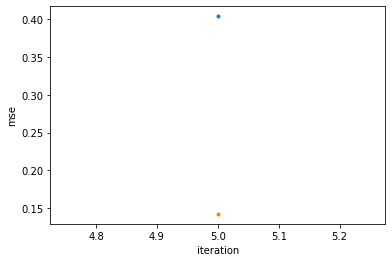

In [179]:
training_rec(nIterRec=5, print_err=True)

Context experiment='switch_context', t_sw=250


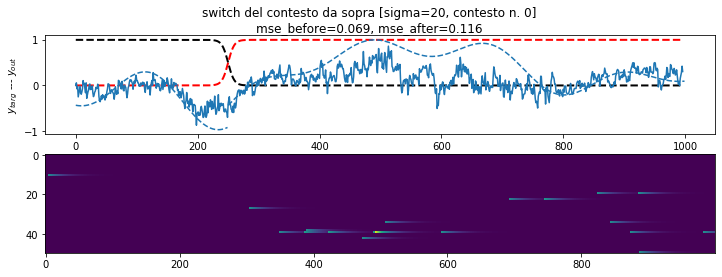

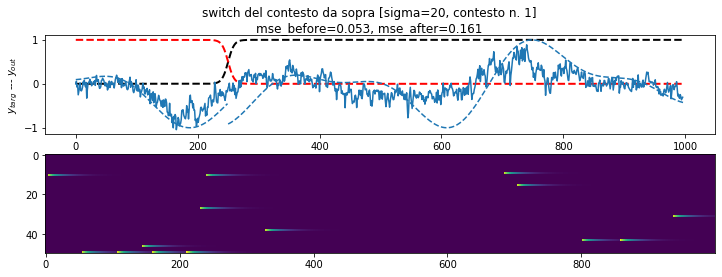

    onDiag: (<mse_before>,<mse_after>) = (0.061,0.139)
    offDiag: (<mse_before>,<mse_after>) = (0.182,0.307)



In [166]:
exp_type = ['none','turn_off_context','switch_context'][2]

res = context_experiment(exp_type=exp_type, t_sw=250, show_plots=True)

In [81]:
cont_index = 1

contexts = res['contexts']
context = contexts[cont_index]
Y = res['outputs'][cont_index]
targ = res['targs'][cont_index]
S_soma = res['S_somas'][cont_index]
S_wind = res['S_winds'][cont_index]

M1 = [S_soma[i][j] if S_wind[i][j]==0 else 0 for i in range(len(S_soma)) for j in range(len(S_soma[i]))]
M2 = [S_soma[i][j] if S_wind[i][j]>0 else 0 for i in range(len(S_soma)) for j in range(len(S_soma[i]))]
M1 = np.array(M1).reshape(np.shape(S_soma))
M2 = np.array(M2).reshape(np.shape(S_soma))

v1 = []
v2 = []
for i in range(np.shape(S_soma)[0]):
    for j in range(np.shape(S_soma)[1]):
        if(M1[i][j]>0):
            v1.append(i)
            v2.append(j)

w1 = []
w2 = []
for i in range(np.shape(S_soma)[0]):
    for j in range(np.shape(S_soma)[1]):
        if(M2[i][j]>0):
            w1.append(i)
            w2.append(j)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


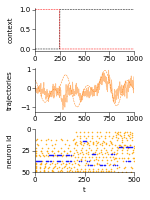

In [82]:
fs = 7
final_dpi = 500

cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5*cm, 7*cm))

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=fs, pad=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)

ax = axes[0]
for d in range(n_contexts):
    ax.plot(context.T[d], zorder=1, ls='--', color=['black','red'][d], lw=0.5)
ax.set_ylabel('', fontsize=fs)
#ax.xaxis.set_ticklabels([])
ax.set_xlim([0,1000])
ax.text(-0.25, 0.5, 'context', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')
    
ax = axes[1]
for d in range(1):
    ax.plot(np.array(Y)[d].T, zorder=0, color='C' + str(d+1), lw=0.75, alpha=0.5)
for d in range(1):
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='C' + str(d+1), lw=0.5)
ax.set_ylabel('', fontsize=fs)
#ax.xaxis.set_ticklabels([])
ax.set_xlim([0,1000])
ax.text(-0.25, 0.5, 'trajectories', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

ax = axes[2]
#ax.imshow(B_filt[0:401,:len(POSITION)+2], zorder=1, aspect='auto')
#ax.imshow(1-(S_soma[:,0:len(POSITION)])*(0.5+S_wind[:,0:len(POSITION)]), aspect='auto', cmap='magma')
cmap1 = matplotlib.colors.ListedColormap(['None','orange'], name='colors', N=None)
cmap2 = matplotlib.colors.ListedColormap(['None','blue'], name='colors', N=None)
#ax.imshow(M1[0:101,:250], cmap=cmap1, aspect='auto', vmin=0, vmax=1)
#ax.imshow(M2[0:101,:250], cmap=cmap2, aspect='auto', vmin=0, vmax=1)
for i in range(len(v1)):
    if(v1[i]>2 and v1[i]<99 and v2[i]>2 and v2[i]<499):
        y = v1[i]
        ax.scatter(v2[i], y, color='orange', marker='.', s=1)
for i in range(len(w1)):
    if(w1[i]>1 and w1[i]<100 and w2[i]>2 and w2[i]<499):
        y = w1[i]
        ax.scatter(w2[i], y, color='blue', marker='.', s=1)
ax.set_xlabel('t', fontsize=fs)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,500])
ax.set_ylim([50,0])
ax.set_xticks([0,250,500])
ax.set_yticks([50,25,0])
ax.text(-0.25, 0.5, 'neuron id', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

plt.tight_layout()
plt.subplots_adjust(left=0.23, bottom=0.12, right=0.93, top=0.95, wspace=None, hspace=0.4)
#fig_title = 'fig_3D_context_%d' % cont_index
fig_title = 'fig_1D_%s_context_%d_%d' % (exp_type,cont_index+1,n_contexts)
for ext in ['eps','pdf','png']:
    plt.savefig('./figures/' + fig_title + '.' + ext, dpi=final_dpi)
plt.show()

In [27]:
# Some trials

sigma_apical_context = 0
sigma_basal_context = 0
dict_key = 'try'
n_trials = 1
t_sw = 500

if False:
    results[dict_key] = {}
    for col_name in ['full_onDiag','full_offDiag',\
                     'turnoff_onDiag_before','turnoff_onDiag_after','turnoff_offDiag_before','turnoff_offDiag_after',\
                     'switch_onDiag_before','switch_onDiag_after','switch_offDiag_before','switch_offDiag_after']:
        results[dict_key][col_name] = []

for trial in range(n_trials):
    
    print('\n##### trial = %d/%d #####\n' % (trial+1,n_trials))
    
    par['sigma_apical_context'] = sigma_apical_context
    par['sigma_basal_context'] = sigma_basal_context
    reload(lttb_module)
    lttb = lttb_module.LTTB (par)
    
    init_clock_targ()
    sparsify_cont(0.75)
    sparsify_targ(0.75)
    
    training_rec(nIterRec=10, eta=10.0, eta_out=0.02, print_err=False)
    
    #training_rec(nIterRec=100, eta=10.0, eta_out=0.02, print_err=False)
    #training_rec(nIterRec=200, eta=5.0, eta_out=0.01, print_err=False)
    #training_rec(nIterRec=200, eta=2.5, eta_out=0.005, print_err=False)
    #training_rec(nIterRec=100, eta=1.25, eta_out=0.0025, print_err=False)
    #training_rec(nIterRec=100, eta=1.25/2, eta_out=0.0025/2, print_err=False)
    
    res0 = context_experiment(exp_type='full_context', t_sw=t_sw, show_plots=True)
    results[dict_key]['full_onDiag'].append(np.mean(res0['mses_onDiag']))
    results[dict_key]['full_offDiag'].append(np.mean(res0['mses_offDiag']))
    
    res1 = context_experiment(exp_type='turnoff_context', t_sw=t_sw, show_plots=True)
    results[dict_key]['turnoff_onDiag_before'].append(np.mean(res1['mses_before_onDiag']))
    results[dict_key]['turnoff_onDiag_after'].append(np.mean(res1['mses_after_onDiag']))
    results[dict_key]['turnoff_offDiag_before'].append(np.mean(res1['mses_before_offDiag']))
    results[dict_key]['turnoff_offDiag_after'].append(np.mean(res1['mses_after_offDiag']))
    
    res2 = context_experiment(exp_type='switch_context', t_sw=t_sw, show_plots=True)
    results[dict_key]['switch_onDiag_before'].append(np.mean(res2['mses_before_onDiag']))
    results[dict_key]['switch_onDiag_after'].append(np.mean(res2['mses_after_onDiag']))
    results[dict_key]['switch_offDiag_before'].append(np.mean(res2['mses_before_offDiag']))
    results[dict_key]['switch_offDiag_after'].append(np.mean(res2['mses_after_offDiag']))


##### trial = 1/1 #####



KeyError: 's_inh'

In [519]:
results.keys()

dict_keys([20, 10, 30, '30_Bfiltrec', '30_RO_new', '10_RO_new', '20_RO_Bias', '20_Bfiltrec_Bias', '50_Bfiltrec_Bias', '2D_50_Bfiltrec_Bias_p08', '2D_50_Bfiltrec_Bias_p02_gradino', '2D_50_Bfiltrec_Bias_p05_gradino', '2D_50_Bfiltrec_Bias_p075_gradino', '2D_50_Bfiltrec_Bias_p075_gradino_doubleSize_sigmaTarg50_input10', '2D_50_Bfiltrec_Bias_p075_gradino_doubleSize_sigmaTarg30_input10', '2D_50_Bfiltrec_Bias_p075_gradino_doubleSize_sigmaTarg30_input20', '2D_sigmaCont20_Bfiltrec_Bias_p075_gradino_doubleSize_sigmaTarg30_input50', '2D_sigmaBasalCont20_Bfiltrec_Bias_p075_gradino_doubleSize_sigmaTarg30_input50'])

In [108]:
# write json on file

if False:
    with open('./results_context_experiments.json', 'w') as fp:
        json.dump(results, fp)

# read json from file

if True:
    
    print('Apical context:')
    file = './results_context_experiments.json'
    with open(file, 'r') as json_file:
        context_old_results = json.load(json_file)
    
    data_list_A = {}
    files = glob.glob('Results_2D_sigmaApicalCont20p00_Bfiltrec_Bias_fracZeroTarg0p75_gradino_N1000_sigmaTarg30p00_input50_withNoise/???_results.json')
    files.sort()
    for file in files:
        n = int(file.split('/')[-1].split('_')[0])
        #print(file,n)
        print(n, end=', ')
        with open(file, 'r') as json_file:
            data_list_A[n] = json.load(json_file)
    print('\n')
    
    print('Basal context:')
    data_list_B = {}
    files = glob.glob('Results_2D_sigmaBasalCont20p00_Bfiltrec_Bias_fracZeroTarg0p75_gradino_N1000_sigmaTarg30p00_input50_withNoise/???_results.json')
    files.sort()
    for file in files:
        n = int(file.split('/')[-1].split('_')[0])
        #print(file,n)
        print(n, end=', ')
        with open(file, 'r') as json_file:
            data_list_B[n] = json.load(json_file)
    print()

Apical context:
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

Basal context:
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 


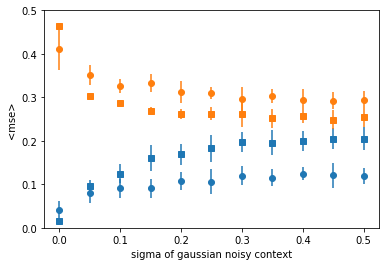

In [594]:
# sopra
data_list = [data1,data2,data3,data4]
x = 0.
y = np.mean([_['full']['MSEs_onDiag'] for _ in data_list])
z = np.std([_['full']['MSEs_onDiag'] for _ in data_list])
plt.errorbar(x,y,z,color='C0',marker='o')
y = np.mean([_['full']['MSEs_offDiag'] for _ in data_list])
z = np.std([_['full']['MSEs_offDiag'] for _ in data_list])
plt.errorbar(x,y,z,color='C1',marker='o')
for val in data1['noisy_full'].keys():
    x = float(val)
    y = np.mean([_['noisy_full'][val]['MSEs_onDiag'] for _ in data_list])
    z = np.std([_['noisy_full'][val]['MSEs_onDiag'] for _ in data_list])
    plt.errorbar(x,y,z,color='C0',marker='o')
    y = np.mean([_['noisy_full'][val]['MSEs_offDiag'] for _ in data_list])
    z = np.std([_['noisy_full'][val]['MSEs_offDiag'] for _ in data_list])
    plt.errorbar(x,y,z,color='C1',marker='o')

# sotto
data_list = [dataB1,dataB2]
x = 0.
y = np.mean([_['full']['MSEs_onDiag'] for _ in data_list])
z = np.std([_['full']['MSEs_onDiag'] for _ in data_list])
plt.errorbar(x,y,z,color='C0',marker='s')
y = np.mean([_['full']['MSEs_offDiag'] for _ in data_list])
z = np.std([_['full']['MSEs_offDiag'] for _ in data_list])
plt.errorbar(x,y,z,color='C1',marker='s')
for val in data1['noisy_full'].keys():
    x = float(val)
    y = np.mean([_['noisy_full'][val]['MSEs_onDiag'] for _ in data_list])
    z = np.std([_['noisy_full'][val]['MSEs_onDiag'] for _ in data_list])
    plt.errorbar(x,y,z,color='C0',marker='s')
    y = np.mean([_['noisy_full'][val]['MSEs_offDiag'] for _ in data_list])
    z = np.std([_['noisy_full'][val]['MSEs_offDiag'] for _ in data_list])
    plt.errorbar(x,y,z,color='C1',marker='s')

plt.xlabel('sigma of gaussian noisy context')
plt.ylabel('<mse>')
plt.ylim([0,0.5])
plt.show()

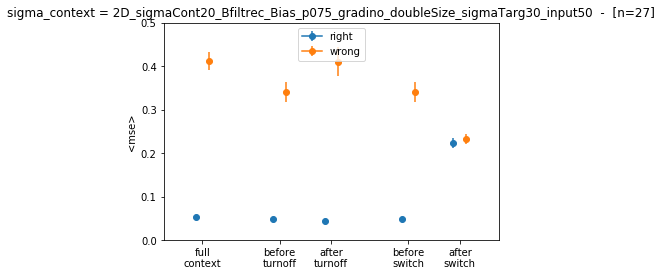

In [537]:
anchors = [1.5,4.5,6.5,9.5,11.5]
dx = 0.25

s_c = '2D_sigmaCont20_Bfiltrec_Bias_p075_gradino_doubleSize_sigmaTarg30_input50'
NN = len(results[s_c]['full_onDiag'])

plt.title('sigma_context = %s  -  [n=%d]' % (s_c,NN))

v = results[s_c]['full_onDiag']
plt.errorbar(x=anchors[0]-dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C0')
v = results[s_c]['full_offDiag']
plt.errorbar(x=anchors[0]+dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C1')

v = results[s_c]['turnoff_onDiag_before']
plt.errorbar(x=anchors[1]-dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C0')
v = results[s_c]['turnoff_offDiag_before']
plt.errorbar(x=anchors[1]+dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C1')

v = results[s_c]['turnoff_onDiag_after']
plt.errorbar(x=anchors[2]-dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C0')
v = results[s_c]['turnoff_offDiag_after']
plt.errorbar(x=anchors[2]+dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C1')

v = results[s_c]['switch_onDiag_before']
plt.errorbar(x=anchors[3]-dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C0')
v = results[s_c]['switch_offDiag_before']
plt.errorbar(x=anchors[3]+dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C1')

v = results[s_c]['switch_onDiag_after']
plt.errorbar(x=anchors[4]-dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C0', label='right')
v = results[s_c]['switch_offDiag_after']
plt.errorbar(x=anchors[4]+dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C1', label='wrong')

plt.xlim([0,13])
plt.ylim([0,0.5])
plt.xticks(anchors,['full\ncontext','before\nturnoff','after\nturnoff','before\nswitch','after\nswitch'])
plt.ylabel('<mse>')

plt.legend(loc='upper center')

plt.show()

Context experiment='full_context', t_sw=500


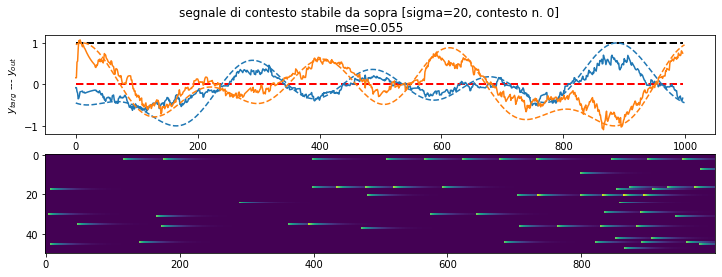

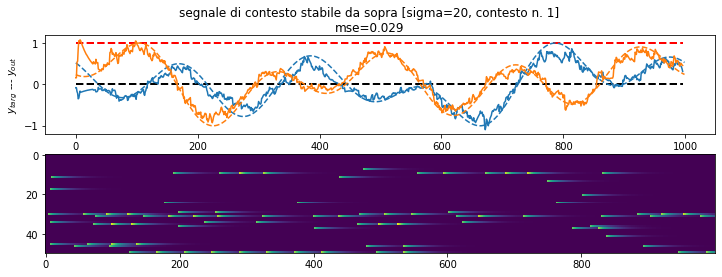

    onDiag: <mse>=0.042
    offDiag: <mse>=0.518

Context experiment='turnoff_context', t_sw=500


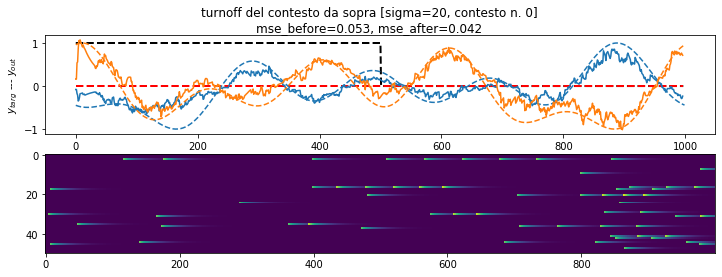

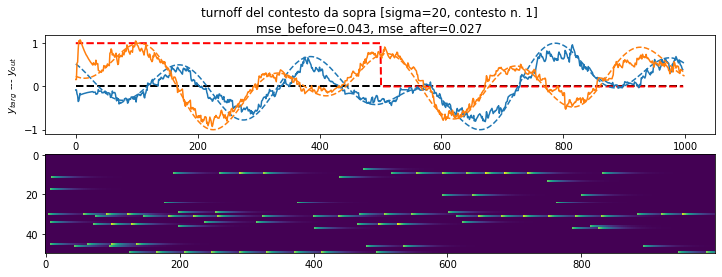

    onDiag: (<mse_before>,<mse_after>) = (0.048,0.034)
    offDiag: (<mse_before>,<mse_after>) = (0.466,0.656)

Context experiment='switch_context', t_sw=500


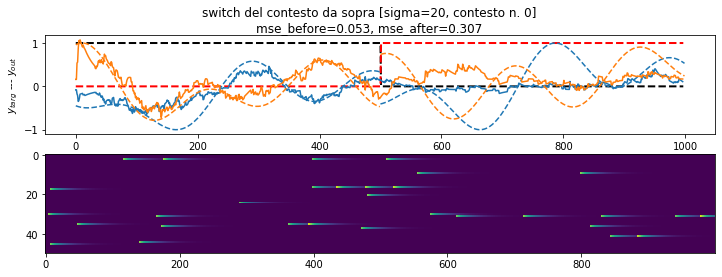

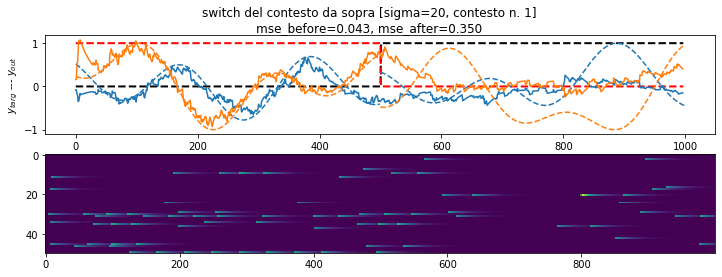

    onDiag: (<mse_before>,<mse_after>) = (0.048,0.328)
    offDiag: (<mse_before>,<mse_after>) = (0.466,0.289)



In [493]:
res0 = context_experiment(exp_type='full_context', t_sw=t_sw, show_plots=True)
results[dict_key]['full_onDiag'].append(np.mean(res0['mses_onDiag']))
results[dict_key]['full_offDiag'].append(np.mean(res0['mses_offDiag']))

res1 = context_experiment(exp_type='turnoff_context', t_sw=t_sw, show_plots=True)
results[dict_key]['turnoff_onDiag_before'].append(np.mean(res1['mses_before_onDiag']))
results[dict_key]['turnoff_onDiag_after'].append(np.mean(res1['mses_after_onDiag']))
results[dict_key]['turnoff_offDiag_before'].append(np.mean(res1['mses_before_offDiag']))
results[dict_key]['turnoff_offDiag_after'].append(np.mean(res1['mses_after_offDiag']))

res2 = context_experiment(exp_type='switch_context', t_sw=t_sw, show_plots=True)
results[dict_key]['switch_onDiag_before'].append(np.mean(res2['mses_before_onDiag']))
results[dict_key]['switch_onDiag_after'].append(np.mean(res2['mses_after_onDiag']))
results[dict_key]['switch_offDiag_before'].append(np.mean(res2['mses_before_offDiag']))
results[dict_key]['switch_offDiag_after'].append(np.mean(res2['mses_after_offDiag']))

In [502]:
cont_index = 1
res = res1

contexts = res['contexts']
context = contexts[cont_index]
Y = res['outputs'][cont_index]
targ = res['targs'][cont_index]
S_soma = res['S_somas'][cont_index]
S_wind = res['S_winds'][cont_index]

M1 = [S_soma[i][j] if S_wind[i][j]==0 else 0 for i in range(len(S_soma)) for j in range(len(S_soma[i]))]
M2 = [S_soma[i][j] if S_wind[i][j]>0 else 0 for i in range(len(S_soma)) for j in range(len(S_soma[i]))]
M1 = np.array(M1).reshape(np.shape(S_soma))
M2 = np.array(M2).reshape(np.shape(S_soma))

v1 = []
v2 = []
for i in range(np.shape(S_soma)[0]):
    for j in range(np.shape(S_soma)[1]):
        if(M1[i][j]>0):
            v1.append(i)
            v2.append(j)

w1 = []
w2 = []
for i in range(np.shape(S_soma)[0]):
    for j in range(np.shape(S_soma)[1]):
        if(M2[i][j]>0):
            w1.append(i)
            w2.append(j)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


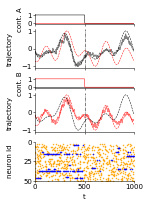

In [734]:
# summary for apical context

res = data_list_A[7]['turnoff']
contexts = res['contexts']

fs = 7
final_dpi = 500

cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5*cm, 7*cm)) # gridspec_kw={'height_ratios': [1, 1, 1]}

axes.set_xlim([0,1])
axes.set_xticks([])
axes.set_ylim([0,1])
axes.set_yticks([])
axes.tick_params(axis='both', which=None, labelsize=fs, pad=1)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_linewidth(False)
axes.spines['bottom'].set_linewidth(False)
#axes.xaxis.set_tick_params(width=0)
#axes.yaxis.set_tick_params(width=0)

axes_list = []

h = 0.06
dh = 0.03
H = (1 - 6*dh - 2*h) / 3

y = 1.00
y -= h
axes_list.append(axes.inset_axes([0.00, y, 1.00, h]))
y -= dh + H
axes_list.append(axes.inset_axes([0.00, y, 1.00, H]))
y -= 2*dh + h
axes_list.append(axes.inset_axes([0.00, y, 1.00, h]))
y -= dh + H
axes_list.append(axes.inset_axes([0.00, y, 1.00, H]))
y -= 2*dh + H
axes_list.append(axes.inset_axes([0.00, y, 1.00, H]))

# first panel - first context

cont_index = 0
context = contexts[cont_index]
Y = res['Ys'][cont_index]
targ = res['targs'][cont_index]
S_soma = res['S_somas'][cont_index]
S_wind = res['S_winds'][cont_index]

M1 = [S_soma[i][j] if S_wind[i][j]==0 else 0 for i in range(len(S_soma)) for j in range(len(S_soma[i]))]
M2 = [S_soma[i][j] if S_wind[i][j]>0 else 0 for i in range(len(S_soma)) for j in range(len(S_soma[i]))]
M1 = np.array(M1).reshape(np.shape(S_soma))
M2 = np.array(M2).reshape(np.shape(S_soma))
v1 = []
v2 = []
for i in range(np.shape(S_soma)[0]):
    for j in range(np.shape(S_soma)[1]):
        if(M1[i][j]>0):
            v1.append(i)
            v2.append(j)
w1 = []
w2 = []
for i in range(np.shape(S_soma)[0]):
    for j in range(np.shape(S_soma)[1]):
        if(M2[i][j]>0):
            w1.append(i)
            w2.append(j)

ax = axes_list[1]
Y = res['Ys'][0]
targ = res['targs'][0]
for d in range(1):
    ax.plot(np.array(Y)[d].T, zorder=0, color='black', lw=0.75, alpha=0.5)
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='black', lw=0.5)
Y = res['Ys'][1]
targ = res['targs'][1]
for d in range(1):
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='red', lw=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,1000])
ax.set_xticks([0,500,1000])
ax.xaxis.set_ticklabels([])
ax.set_ylim([-1.1,1.1])
ax.text(-0.25, 0.5, 'trajectory', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor')
ymin, ymax = ax.get_ylim()
ax.set_ylim([ymin,ymax])
ax.plot([500,500], [ymin,ymax], ls='-.', color='black', lw=0.5, zorder=-1)

#ins_ax_0 = ax.inset_axes([0.00, 1.05, 1.00, 0.20])
ax = axes_list[0]
for d in range(n_contexts):
    ax.plot(np.array(context).T[d], zorder=1, ls='-', color=['black','red'][d], lw=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xticks([0,500,1000])
ax.xaxis.set_ticklabels([])
ax.set_xlim([0,1000])
ax.set_ylim([-0.1,1.1])
#ax.set_title('context', fontsize=fs)
ax.text(-0.15, 0.5, 'cont. A', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor')

# second panel - second context

cont_index = 1
context = contexts[cont_index]
Y = res['Ys'][cont_index]
targ = res['targs'][cont_index]
S_soma = res['S_somas'][cont_index]
S_wind = res['S_winds'][cont_index]

ax = axes_list[3]
Y = res['Ys'][0]
targ = res['targs'][0]
for d in range(1):
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='black', lw=0.5)
Y = res['Ys'][1]
targ = res['targs'][1]
for d in range(1):
    ax.plot(np.array(Y)[d].T, zorder=0, color='red', lw=0.75, alpha=0.5)
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='red', lw=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,1000])
ax.set_xticks([0,500,1000])
ax.xaxis.set_ticklabels([])
ax.set_ylim([-1.1,1.1])
ax.text(-0.25, 0.5, 'trajectory', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor')
ymin, ymax = ax.get_ylim()
ax.set_ylim([ymin,ymax])
ax.plot([500,500], [ymin,ymax], ls='-.', color='black', lw=0.5, zorder=-1)

#ins_ax_1 = ax.inset_axes([0.00, 1.05, 1.00, 0.20])
ax = axes_list[2]
for d in range(n_contexts):
    ax.plot(np.array(context).T[d], zorder=1, ls='-', color=['black','red'][d], lw=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xticks([0,500,1000])
ax.xaxis.set_ticklabels([])
ax.set_xlim([0,1000])
ax.set_ylim([-0.1,1.1])
#ax.set_title('context', fontsize=fs)
ax.text(-0.15, 0.5, 'cont. B', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor')








ax = axes_list[4]
#ax.imshow(B_filt[0:401,:len(POSITION)+2], zorder=1, aspect='auto')
#ax.imshow(1-(S_soma[:,0:len(POSITION)])*(0.5+S_wind[:,0:len(POSITION)]), aspect='auto', cmap='magma')
cmap1 = matplotlib.colors.ListedColormap(['None','orange'], name='colors', N=None)
cmap2 = matplotlib.colors.ListedColormap(['None','blue'], name='colors', N=None)
#ax.imshow(M1[0:101,:250], cmap=cmap1, aspect='auto', vmin=0, vmax=1)
#ax.imshow(M2[0:101,:250], cmap=cmap2, aspect='auto', vmin=0, vmax=1)
for i in range(len(v1)):
    if(v1[i]>2 and v1[i]<99 and v2[i]>2 and v2[i]<999):
        y = v1[i]
        ax.scatter(v2[i], y, color='orange', marker='.', s=1)
for i in range(len(w1)):
    if(w1[i]>1 and w1[i]<100 and w2[i]>2 and w2[i]<999):
        y = w1[i]
        ax.scatter(w2[i], y, color='blue', marker='.', s=1)
ax.set_xlabel('t', fontsize=fs)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,1000])
ax.set_ylim([50,0])
ax.set_xticks([0,500,1000])
ax.set_yticks([50,25,0])
ax.text(-0.25, 0.5, 'neuron id', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor')

for ax in axes_list:
    ax.tick_params(axis='both', which='major', labelsize=fs, pad=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5, length=2)
    ax.yaxis.set_tick_params(width=0.5, length=2)

plt.tight_layout()
plt.subplots_adjust(left=0.23, bottom=0.10, right=0.93, top=0.94, wspace=None, hspace=0.5)
#fig_title = 'fig_3D_context_%d' % cont_index
fig_title = 'summary_2D_contesto_apicale'
for ext in ['eps','pdf','png']:
    plt.savefig('./figures/' + fig_title + '.' + ext, dpi=final_dpi)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


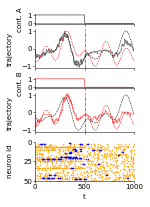

In [735]:
# summary for basal context

res = data_list_B[7]['turnoff']
contexts = res['contexts']

fs = 7
final_dpi = 500

cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5*cm, 7*cm)) # gridspec_kw={'height_ratios': [1, 1, 1]}

axes.set_xlim([0,1])
axes.set_xticks([])
axes.set_ylim([0,1])
axes.set_yticks([])
axes.tick_params(axis='both', which=None, labelsize=fs, pad=1)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_linewidth(False)
axes.spines['bottom'].set_linewidth(False)
#axes.xaxis.set_tick_params(width=0)
#axes.yaxis.set_tick_params(width=0)

axes_list = []

h = 0.06
dh = 0.03
H = (1 - 6*dh - 2*h) / 3

y = 1.00
y -= h
axes_list.append(axes.inset_axes([0.00, y, 1.00, h]))
y -= dh + H
axes_list.append(axes.inset_axes([0.00, y, 1.00, H]))
y -= 2*dh + h
axes_list.append(axes.inset_axes([0.00, y, 1.00, h]))
y -= dh + H
axes_list.append(axes.inset_axes([0.00, y, 1.00, H]))
y -= 2*dh + H
axes_list.append(axes.inset_axes([0.00, y, 1.00, H]))

# first panel - first context

cont_index = 0
context = contexts[cont_index]
Y = res['Ys'][cont_index]
targ = res['targs'][cont_index]
S_soma = res['S_somas'][cont_index]
S_wind = res['S_winds'][cont_index]

M1 = [S_soma[i][j] if S_wind[i][j]==0 else 0 for i in range(len(S_soma)) for j in range(len(S_soma[i]))]
M2 = [S_soma[i][j] if S_wind[i][j]>0 else 0 for i in range(len(S_soma)) for j in range(len(S_soma[i]))]
M1 = np.array(M1).reshape(np.shape(S_soma))
M2 = np.array(M2).reshape(np.shape(S_soma))
v1 = []
v2 = []
for i in range(np.shape(S_soma)[0]):
    for j in range(np.shape(S_soma)[1]):
        if(M1[i][j]>0):
            v1.append(i)
            v2.append(j)
w1 = []
w2 = []
for i in range(np.shape(S_soma)[0]):
    for j in range(np.shape(S_soma)[1]):
        if(M2[i][j]>0):
            w1.append(i)
            w2.append(j)

ax = axes_list[1]
Y = res['Ys'][0]
targ = res['targs'][0]
for d in range(1):
    ax.plot(np.array(Y)[d].T, zorder=0, color='black', lw=0.75, alpha=0.5)
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='black', lw=0.5)
Y = res['Ys'][1]
targ = res['targs'][1]
for d in range(1):
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='red', lw=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,1000])
ax.set_xticks([0,500,1000])
ax.xaxis.set_ticklabels([])
ax.set_ylim([-1.1,1.1])
ax.text(-0.25, 0.5, 'trajectory', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor')
ymin, ymax = ax.get_ylim()
ax.set_ylim([ymin,ymax])
ax.plot([500,500], [ymin,ymax], ls='-.', color='black', lw=0.5, zorder=-1)

#ins_ax_0 = ax.inset_axes([0.00, 1.05, 1.00, 0.20])
ax = axes_list[0]
for d in range(n_contexts):
    ax.plot(np.array(context).T[d], zorder=1, ls='-', color=['black','red'][d], lw=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xticks([0,500,1000])
ax.xaxis.set_ticklabels([])
ax.set_xlim([0,1000])
ax.set_ylim([-0.1,1.1])
#ax.set_title('context', fontsize=fs)
ax.text(-0.15, 0.5, 'cont. A', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor')

# second panel - second context

cont_index = 1
context = contexts[cont_index]
Y = res['Ys'][cont_index]
targ = res['targs'][cont_index]
S_soma = res['S_somas'][cont_index]
S_wind = res['S_winds'][cont_index]

ax = axes_list[3]
Y = res['Ys'][0]
targ = res['targs'][0]
for d in range(1):
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='black', lw=0.5)
Y = res['Ys'][1]
targ = res['targs'][1]
for d in range(1):
    ax.plot(np.array(Y)[d].T, zorder=0, color='red', lw=0.75, alpha=0.5)
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='red', lw=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,1000])
ax.set_xticks([0,500,1000])
ax.xaxis.set_ticklabels([])
ax.set_ylim([-1.1,1.1])
ax.text(-0.25, 0.5, 'trajectory', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor')
ymin, ymax = ax.get_ylim()
ax.set_ylim([ymin,ymax])
ax.plot([500,500], [ymin,ymax], ls='-.', color='black', lw=0.5, zorder=-1)

#ins_ax_1 = ax.inset_axes([0.00, 1.05, 1.00, 0.20])
ax = axes_list[2]
for d in range(n_contexts):
    ax.plot(np.array(context).T[d], zorder=1, ls='-', color=['black','red'][d], lw=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xticks([0,500,1000])
ax.xaxis.set_ticklabels([])
ax.set_xlim([0,1000])
ax.set_ylim([-0.1,1.1])
#ax.set_title('context', fontsize=fs)
ax.text(-0.15, 0.5, 'cont. B', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor')








ax = axes_list[4]
#ax.imshow(B_filt[0:401,:len(POSITION)+2], zorder=1, aspect='auto')
#ax.imshow(1-(S_soma[:,0:len(POSITION)])*(0.5+S_wind[:,0:len(POSITION)]), aspect='auto', cmap='magma')
cmap1 = matplotlib.colors.ListedColormap(['None','orange'], name='colors', N=None)
cmap2 = matplotlib.colors.ListedColormap(['None','blue'], name='colors', N=None)
#ax.imshow(M1[0:101,:250], cmap=cmap1, aspect='auto', vmin=0, vmax=1)
#ax.imshow(M2[0:101,:250], cmap=cmap2, aspect='auto', vmin=0, vmax=1)
for i in range(len(v1)):
    if(v1[i]>2 and v1[i]<99 and v2[i]>2 and v2[i]<999):
        y = v1[i]
        ax.scatter(v2[i], y, color='orange', marker='.', s=1)
for i in range(len(w1)):
    if(w1[i]>1 and w1[i]<100 and w2[i]>2 and w2[i]<999):
        y = w1[i]
        ax.scatter(w2[i], y, color='blue', marker='.', s=1)
ax.set_xlabel('t', fontsize=fs)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,1000])
ax.set_ylim([50,0])
ax.set_xticks([0,500,1000])
ax.set_yticks([50,25,0])
ax.text(-0.25, 0.5, 'neuron id', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor')

for ax in axes_list:
    ax.tick_params(axis='both', which='major', labelsize=fs, pad=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5, length=2)
    ax.yaxis.set_tick_params(width=0.5, length=2)

plt.tight_layout()
plt.subplots_adjust(left=0.23, bottom=0.10, right=0.93, top=0.94, wspace=None, hspace=0.5)
#fig_title = 'fig_3D_context_%d' % cont_index
fig_title = 'summary_2D_contesto_basale'
for ext in ['eps','pdf','png']:
    plt.savefig('./figures/' + fig_title + '.' + ext, dpi=final_dpi)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

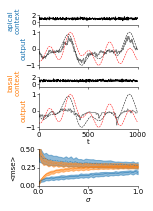

In [109]:
res = data_list_A[7]['noisy_full']['0.2']
contexts = res['contexts']

fs = 7
final_dpi = 500

cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5*cm, 7*cm)) # gridspec_kw={'height_ratios': [1, 1, 1]}

axes.set_xlim([0,1])
axes.set_xticks([])
axes.set_ylim([0,1])
axes.set_yticks([])
axes.tick_params(axis='both', which=None, labelsize=fs, pad=1)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_linewidth(False)
axes.spines['bottom'].set_linewidth(False)
#axes.xaxis.set_tick_params(width=0)
#axes.yaxis.set_tick_params(width=0)

axes_list = []

h = 0.06
dh = 0.03
H = (1 - 8*dh - 2*h) / 3

y = 1.00
y -= h
axes_list.append(axes.inset_axes([0.00, y, 1.00, h]))
y -= dh + H
axes_list.append(axes.inset_axes([0.00, y, 1.00, H]))
y -= 2*dh + h
axes_list.append(axes.inset_axes([0.00, y, 1.00, h]))
y -= dh + H
axes_list.append(axes.inset_axes([0.00, y, 1.00, H]))
y -= 4*dh + H
axes_list.append(axes.inset_axes([0.00, y, 1.00, H]))

# first panel - first context

cont_index = 0
context = contexts[cont_index]
Y = res['Ys'][cont_index]
targ = res['targs'][cont_index]
#S_soma = res['S_somas'][cont_index]
#S_wind = res['S_winds'][cont_index]

ax = axes_list[1]
Y = res['Ys'][0]
targ = res['targs'][0]
for d in range(1):
    ax.plot(np.array(Y)[d].T, zorder=0, color='black', lw=0.75, alpha=0.5)
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='black', lw=0.5)
Y = res['Ys'][1]
targ = res['targs'][1]
for d in range(1):
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='red', lw=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,1000])
ax.set_xticks([0,500,1000])
ax.xaxis.set_ticklabels([])
ax.set_ylim([-1.1,1.1])
ax.text(-0.15, 0.5, 'output', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor', color='C0')
ymin, ymax = ax.get_ylim()
ax.set_ylim([ymin,ymax])
#ax.plot([500,500], [ymin,ymax], ls='-.', color='black', lw=0.5, zorder=-1)

#ins_ax_0 = ax.inset_axes([0.00, 1.05, 1.00, 0.20])
ax = axes_list[0]
for d in range(n_contexts):
    ax.plot(np.array(context).T[d], zorder=1, ls='-', color=['black','red'][d], lw=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xticks([0,500,1000])
ax.xaxis.set_ticklabels([])
ax.set_xlim([0,1000])
ax.set_ylim([-1.1,2.1])
#ax.set_title('context', fontsize=fs)
ax.text(-0.25, 0.5, 'apical\ncontext', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor', color='C0')

# second panel - second context

res = data_list_B[7]['noisy_full']['0.2']
contexts = res['contexts']

cont_index = 0
context = contexts[cont_index]
Y = res['Ys'][cont_index]
targ = res['targs'][cont_index]
#S_soma = res['S_somas'][cont_index]
#S_wind = res['S_winds'][cont_index]

ax = axes_list[3]
Y = res['Ys'][0]
targ = res['targs'][0]
for d in range(1):
    ax.plot(np.array(Y)[d].T, zorder=0, color='black', lw=0.75, alpha=0.5)
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='black', lw=0.5)
Y = res['Ys'][1]
targ = res['targs'][1]
for d in range(1):
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='red', lw=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,1000])
ax.set_xticks([0,500,1000])
#ax.xaxis.set_ticklabels([])
ax.set_ylim([-1.1,1.1])
ax.text(-0.15, 0.5, 'output', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor', color='C1')
ymin, ymax = ax.get_ylim()
ax.set_ylim([ymin,ymax])
#ax.plot([500,500], [ymin,ymax], ls='-.', color='black', lw=0.5, zorder=-1)
ax.set_xlabel('t', fontsize=fs)
ax.xaxis.labelpad = 1

#ins_ax_1 = ax.inset_axes([0.00, 1.05, 1.00, 0.20])
ax = axes_list[2]
for d in range(n_contexts):
    ax.plot(np.array(context).T[d], zorder=1, ls='-', color=['black','red'][d], lw=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xticks([0,500,1000])
ax.xaxis.set_ticklabels([])
ax.set_xlim([0,1000])
ax.set_ylim([-1.1,2.1])
#ax.set_title('context', fontsize=fs)
ax.text(-0.25, 0.5, 'basal\ncontext', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor', color='C1')

ax = axes_list[4]

x = []
y = []
z = []
#x.append(0.)
#y.append(np.mean([data_list_A[_]['full']['MSEs_onDiag'] for _ in data_list_A.keys() if val in data_list_A[_]['noisy_full'].keys()]))
#z.append(np.std([data_list_A[_]['full']['MSEs_onDiag'] for _ in data_list_A.keys() if val in data_list_A[_]['noisy_full'].keys()]))
for val in np.arange(0.00,1.01,0.025): # data1['noisy_full'].keys():
    val = str(round(val,4))
    x.append(float(val))
    y.append(np.mean([data_list_A[_]['noisy_full'][val]['MSEs_onDiag'] for _ in data_list_A.keys() if val in data_list_A[_]['noisy_full'].keys()]))
    z.append(np.std([data_list_A[_]['noisy_full'][val]['MSEs_onDiag'] for _ in data_list_A.keys() if val in data_list_A[_]['noisy_full'].keys()]))
ax.fill_between(x,np.array(y)-np.array(z),np.array(y)+np.array(z),alpha=0.5,color='C0')
ax.plot(x,y,color='C0',ls='-',lw=0.5)

x = []
y = []
z = []
#x.append(0.)
#y.append(np.mean([data_list_A[_]['full']['MSEs_offDiag'] for _ in data_list_A.keys() if val in data_list_A[_]['noisy_full'].keys()]))
#z.append(np.std([data_list_A[_]['full']['MSEs_offDiag'] for _ in data_list_A.keys() if val in data_list_A[_]['noisy_full'].keys()]))
for val in np.arange(0.00,1.01,0.025): # data1['noisy_full'].keys():
    val = str(round(val,4))
    x.append(float(val))
    y.append(np.mean([data_list_A[_]['noisy_full'][val]['MSEs_offDiag'] for _ in data_list_A.keys() if val in data_list_A[_]['noisy_full'].keys()]))
    z.append(np.std([data_list_A[_]['noisy_full'][val]['MSEs_offDiag'] for _ in data_list_A.keys() if val in data_list_A[_]['noisy_full'].keys()]))
ax.fill_between(x,np.array(y)-np.array(z),np.array(y)+np.array(z),alpha=0.5,color='C0')
ax.plot(x,y,color='C0',ls='--',lw=0.5)

x = []
y = []
z = []
#x.append(0.)
#y.append(np.mean([data_list_B[_]['full']['MSEs_onDiag'] for _ in data_list_B.keys() if val in data_list_B[_]['noisy_full'].keys()]))
#z.append(np.std([data_list_B[_]['full']['MSEs_onDiag'] for _ in data_list_B.keys() if val in data_list_B[_]['noisy_full'].keys()]))
for val in np.arange(0.00,1.01,0.025): # data1['noisy_full'].keys():
    val = str(round(val,4))
    x.append(float(val))
    y.append(np.mean([data_list_B[_]['noisy_full'][val]['MSEs_onDiag'] for _ in data_list_B.keys() if val in data_list_B[_]['noisy_full'].keys()]))
    z.append(np.std([data_list_B[_]['noisy_full'][val]['MSEs_onDiag'] for _ in data_list_B.keys() if val in data_list_B[_]['noisy_full'].keys()]))
ax.fill_between(x,np.array(y)-np.array(z),np.array(y)+np.array(z),alpha=0.5,color='C1')
ax.plot(x,y,color='C1',ls='-',lw=0.5)

x = []
y = []
z = []
#x.append(0.)
#y.append(np.mean([data_list_B[_]['full']['MSEs_offDiag'] for _ in data_list_B.keys() if val in data_list_B[_]['noisy_full'].keys()]))
#z.append(np.std([data_list_B[_]['full']['MSEs_offDiag'] for _ in data_list_B.keys() if val in data_list_B[_]['noisy_full'].keys()]))
for val in np.arange(0.00,1.01,0.025): # data1['noisy_full'].keys():
    val = str(round(val,4))
    x.append(float(val))
    y.append(np.mean([data_list_B[_]['noisy_full'][val]['MSEs_offDiag'] for _ in data_list_B.keys() if val in data_list_B[_]['noisy_full'].keys()]))
    z.append(np.std([data_list_B[_]['noisy_full'][val]['MSEs_offDiag'] for _ in data_list_B.keys() if val in data_list_B[_]['noisy_full'].keys()]))
ax.fill_between(x,np.array(y)-np.array(z),np.array(y)+np.array(z),alpha=0.5,color='C1')
ax.plot(x,y,color='C1',ls='--',lw=0.5)

ax.set_xlabel(r'$\sigma$', fontsize=fs)
ax.xaxis.labelpad = 1
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,1.0])
ax.set_ylim([0,0.5])
ax.set_xticks([0,0.50,1.00])
ax.set_yticks([0,0.25,0.50])
ax.text(-0.25, 0.5, '<mse>', fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes, rotation_mode='anchor')

#plt.errorbar(x,y,z,color='C0',marker='o')
"""y = np.mean([_['full']['MSEs_offDiag'] for _ in data_list_A])
z = np.std([_['full']['MSEs_offDiag'] for _ in data_list_A])
plt.errorbar(x,y,z,color='C1',marker='o')

    plt.errorbar(x,y,z,color='C0',marker='o')
    y = np.mean([_['noisy_full'][val]['MSEs_offDiag'] for _ in data_list_A])
    z = np.std([_['noisy_full'][val]['MSEs_offDiag'] for _ in data_list_A])
    plt.errorbar(x,y,z,color='C1',marker='o')
"""

for ax in axes_list:
    ax.tick_params(axis='both', which='major', labelsize=fs, pad=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5, length=2)
    ax.yaxis.set_tick_params(width=0.5, length=2)

plt.tight_layout()
plt.subplots_adjust(left=0.23, bottom=0.09, right=0.93, top=0.95, wspace=None, hspace=0.5)
#fig_title = 'fig_3D_context_%d' % cont_index
fig_title = 'summary_2D_noisy'
for ext in ['eps','pdf','png']:
    plt.savefig('./figures/' + fig_title + '.' + ext, dpi=final_dpi)
plt.show()

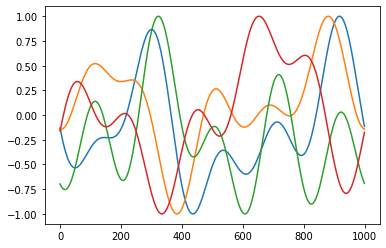

In [729]:
#np.save(outfile, x)

gg = []
lttb.init_targ(par)
gg.append(lttb.y_targ)
lttb.init_targ(par)
gg.append(lttb.y_targ)
gg = np.array(gg)

plt.plot(gg[0].T)
plt.plot(gg[1].T)

#plt.plot(np.array(data_list_A[1]['noisy_full']['0.2']['targs'][0]).T)
#plt.plot(np.array(data_list_A[1]['noisy_full']['0.2']['targs'][1]).T)

plt.show()

#np.save('./sample_targ', np.array(data_list_A[1]['noisy_full']['0.2']['targs']))
np.save('./sample_targ', gg)

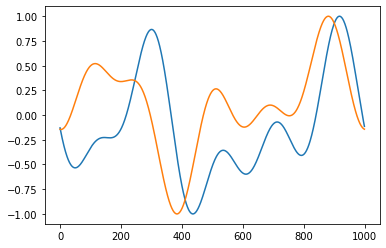

1000


In [730]:
gh = np.load('./sample_targ.npy')

plt.plot(gh[0].T)
#plt.plot(gh[1].T)
plt.show()

print(len(gh[0][1]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


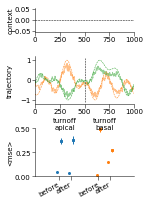

In [55]:
fs = 7
final_dpi = 500

cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5*cm, 7*cm), gridspec_kw={'height_ratios': [1, 2, 2]})

key1 = '2D_sigmaCont20_Bfiltrec_Bias_p075_gradino_doubleSize_sigmaTarg30_input50'
key2 = '2D_sigmaBasalCont20_Bfiltrec_Bias_p075_gradino_doubleSize_sigmaTarg30_input50'

res = data_list_A[7]['turnoff']
cont_index = 1
contexts = res['contexts']
context = contexts[cont_index]
Y = res['Ys'][cont_index]
targ = res['targs'][cont_index]
S_soma = res['S_somas'][cont_index]
S_wind = res['S_winds'][cont_index]

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=fs, pad=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)

ax = axes[0]
for d in range(n_contexts):
    ax.plot(np.array(context).T[d], zorder=1, ls='--', color=['black','red'][d], lw=0.5)
ax.set_ylabel('', fontsize=fs)
#ax.xaxis.set_ticklabels([])
ax.set_xlim([0,1000])
ax.text(-0.25, 0.5, 'context', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')
#ax.text(0.5, 1.0, '$t^*$', fontsize=fs, ha='center', va='bottom', rotation=0, \
#        transform=ax.transAxes, rotation_mode='anchor')
    
ax = axes[1]
for d in range(2):
    ax.plot(np.array(Y)[d].T, zorder=0, color='C' + str(d+1), lw=0.75, alpha=0.5)
for d in range(2):
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='C' + str(d+1), lw=0.5)
ymin, ymax = ax.get_ylim()
ax.set_xlim([ymin,ymax])
ax.plot([500,500], [ymin,ymax], ls='--', color='black', lw=0.5, zorder=-1)
ax.set_ylabel('', fontsize=fs)
#ax.xaxis.set_ticklabels([])
ax.set_xlim([0,1000])
ax.text(-0.25, 0.5, 'trajectory', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

ax = axes[2]
anchors = [1.2,1.8,3.2,3.8]
dx = 0.1
ms = 2
lw = 1

# full
#v = results[key1]['full_onDiag']
#ax.errorbar(x=anchors[0]-dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C0', markersize=ms, lw=lw)
#v = results[key1]['full_offDiag']
#ax.errorbar(x=anchors[0]+dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C1', markersize=ms, lw=lw)

# turnoff - contesto apicale
#v = context_old_results[key1]['turnoff_onDiag_before']
v = [data_list_A[_]['turnoff']['MSEs_onDiag_before'] for _ in data_list_A.keys()]
ax.errorbar(x=anchors[0]-dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(len(v)-1), marker='o', color='C0', markersize=ms, lw=lw)
#v = context_old_results[key1]['turnoff_offDiag_before']
v = [data_list_A[_]['turnoff']['MSEs_offDiag_before'] for _ in data_list_A.keys()]
ax.errorbar(x=anchors[0]+dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(len(v)-1), marker='s', color='C0', markersize=ms, lw=lw)
#v = context_old_results[key1]['turnoff_onDiag_after']
v = [data_list_A[_]['turnoff']['MSEs_onDiag_after'] for _ in data_list_A.keys()]
ax.errorbar(x=anchors[1]-dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(len(v)-1), marker='o', color='C0', markersize=ms, lw=lw)
#v = context_old_results[key1]['turnoff_offDiag_after']
v = [data_list_A[_]['turnoff']['MSEs_offDiag_after'] for _ in data_list_A.keys()]
ax.errorbar(x=anchors[1]+dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(len(v)-1), marker='s', color='C0', markersize=ms, lw=lw)

"""
# switch - contesto apicale
v = results[key1]['switch_onDiag_before']
ax.errorbar(x=anchors[3]-dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C0', markersize=ms, lw=lw)
v = results[key1]['switch_offDiag_before']
ax.errorbar(x=anchors[3]+dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C1', markersize=ms, lw=lw)
v = results[key1]['switch_onDiag_after']
ax.errorbar(x=anchors[4]-dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C0', markersize=ms, lw=lw, label='right')
v = results[key1]['switch_offDiag_after']
ax.errorbar(x=anchors[4]+dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(NN-1), marker='o', color='C1', markersize=ms, lw=lw, label='wrong')
"""

# turnoff - contesto basale

#v = context_old_results[key2]['turnoff_onDiag_before']
v = [data_list_B[_]['turnoff']['MSEs_onDiag_before'] for _ in data_list_B.keys()]
ax.errorbar(x=anchors[2]-dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(len(v)-1), marker='o', color='C1', markersize=ms, lw=lw)
#v = context_old_results[key2]['turnoff_offDiag_before']
v = [data_list_B[_]['turnoff']['MSEs_offDiag_before'] for _ in data_list_B.keys()]
ax.errorbar(x=anchors[2]+dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(len(v)-1), marker='s', color='C1', markersize=ms, lw=lw)
#v = context_old_results[key2]['turnoff_onDiag_after']
v = [data_list_B[_]['turnoff']['MSEs_onDiag_after'] for _ in data_list_B.keys()]
ax.errorbar(x=anchors[3]-dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(len(v)-1), marker='o', color='C1', markersize=ms, lw=lw, label='right')
#v = context_old_results[key2]['turnoff_offDiag_after']
v = [data_list_B[_]['turnoff']['MSEs_offDiag_after'] for _ in data_list_B.keys()]
ax.errorbar(x=anchors[3]+dx, y=np.mean(v), yerr=np.std(v)/np.sqrt(len(v)-1), marker='s', color='C1', markersize=ms, lw=lw, label='wrong')

ax.set_xlabel('', fontsize=fs)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,5])
ax.set_ylim([0,0.5])
ax.set_xticks(anchors)
#ax.text(anchors[0], 0.48, 'full', fontsize=fs, ha='center', va='center')
ax.text(0.5*(anchors[0]+anchors[1]), 0.55, 'turnoff\napical', fontsize=fs, ha='center', va='center')
ax.text(0.5*(anchors[2]+anchors[3]), 0.55, 'turnoff\nbasal', fontsize=fs, ha='center', va='center')
ax.xaxis.set_ticklabels(['before','after','before','after'], fontsize=fs, rotation=30, ha='right', va='center', rotation_mode='anchor')
ax.tick_params(axis='x', which='major', pad=3)
ax.set_yticks([0,0.25,0.50])
ax.text(-0.25, 0.5, '<mse>', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

plt.tight_layout()
plt.subplots_adjust(left=0.23, bottom=0.10, right=0.93, top=0.95, wspace=None, hspace=0.6)
fig_title = 'summary_2D_turnoff'
for ext in ['eps','pdf','png']:
    plt.savefig('./figures/' + fig_title + '.' + ext, dpi=final_dpi)
plt.show()

In [7]:
dict_contesto_apicale_turnoff = {}
dict_contesto_apicale_switch = {}

In [8]:
dict_contesto_apicale_turnoff[5] = [(0.181,0.173,0.253,0.291),(0.144,0.118,0.418,0.270),(0.128,0.168,0.199,0.208),\
                                    (0.174,0.161,0.310,0.270),(0.191,0.188,0.540,0.246),(0.136,0.143,0.313,0.183),\
                                    (0.152,0.142,0.289,0.306),(0.276,0.203,0.343,0.299),(0.167,0.102,0.627,0.166),\
                                    (0.161,0.136,0.491,0.193)]
dict_contesto_apicale_switch[5] = [(0.181,0.217,0.253,0.280),(0.144,0.212,0.418,0.233),(0.128,0.125,0.199,0.299),\
                                   (0.174,0.183,0.310,0.308),(0.191,0.179,0.540,0.298),(0.136,0.166,0.313,0.224),\
                                   (0.152,0.166,0.289,0.311),(0.276,0.219,0.343,0.332),(0.167,0.116,0.627,0.167),\
                                   (0.161,0.146,0.491,0.243)]

In [9]:
dict_contesto_apicale_turnoff[10] = [(0.217,0.184,0.548,0.350),(0.136,0.180,0.353,0.369),(0.069,0.141,0.245,0.268),\
                                     (0.097,0.132,0.413,0.216),(0.105,0.150,0.277,0.294),(0.180,0.132,0.461,0.182),\
                                     (0.107,0.134,0.289,0.248),(0.138,0.133,0.458,0.196),(0.077,0.132,0.181,0.313),\
                                     (0.127,0.197,0.327,0.306)]
dict_contesto_apicale_switch[10] = [(0.217,0.218,0.548,0.402),(0.136,0.185,0.353,0.396),(0.069,0.164,0.245,0.293),\
                                    (0.097,0.127,0.413,0.285),(0.105,0.163,0.277,0.379),(0.180,0.149,0.461,0.215),\
                                    (0.107,0.159,0.289,0.357),(0.138,0.166,0.458,0.253),(0.077,0.151,0.181,0.402),\
                                    (0.127,0.143,0.327,0.448)]

In [10]:
dict_contesto_apicale_turnoff[20] = [(0.122,0.154,0.365,0.272),(0.060,0.138,0.795,0.216),(0.081,0.209,0.279,0.254),\
                                     (0.116,0.180,0.375,0.272),(0.117,0.160,0.566,0.259),(0.133,0.187,0.206,0.288),\
                                     (0.111,0.177,0.425,0.318),(0.144,0.188,0.437,0.346),(0.058,0.168,0.274,0.288),\
                                     (0.102,0.167,0.335,0.260)]
dict_contesto_apicale_switch[20] = [(0.122,0.132,0.365,0.353),(0.060,0.093,0.795,0.394),(0.081,0.144,0.279,0.419),\
                                    (0.116,0.155,0.375,0.371),(0.117,0.165,0.566,0.318),(0.133,0.141,0.206,0.382),\
                                    (0.111,0.144,0.425,0.390),(0.144,0.202,0.437,0.348),(0.058,0.137,0.274,0.349),\
                                    (0.102,0.153,0.335,0.338)]

In [11]:
dict_contesto_apicale_turnoff[30] = [(0.074,0.138,0.146,0.233),(0.053,0.168,0.288,0.373),(0.084,0.228,0.196,0.297),\
                                     (0.093,0.173,0.504,0.255),(0.086,0.166,0.323,0.303),(0.049,0.202,0.188,0.326),\
                                     (0.083,0.257,0.575,0.360),(0.068,0.196,0.325,0.273),(0.086,0.217,0.204,0.227),\
                                     (0.078,0.186,0.240,0.286)]
dict_contesto_apicale_switch[30] = [(0.074,0.096,0.146,0.361),(0.053,0.147,0.288,0.403),(0.084,0.108,0.196,0.503),\
                                    (0.093,0.124,0.504,0.354),(0.086,0.127,0.323,0.427),(0.049,0.153,0.188,0.382),\
                                    (0.083,0.170,0.575,0.500),(0.068,0.107,0.325,0.374),(0.086,0.106,0.204,0.404),\
                                    (0.078,0.115,0.240,0.510)]

In [12]:
dict_contesto_apicale_turnoff[40] = [(0.092,0.201,0.341,0.343),(0.060,0.211,0.471,0.327),(0.038,0.219,0.120,0.274),\
                                     (0.058,0.191,0.192,0.308),(0.057,0.186,0.393,0.224),(0.053,0.179,0.114,0.276),\
                                     (0.045,0.192,0.240,0.243),(0.069,0.190,0.287,0.235),(0.060,0.195,0.395,0.311),\
                                     (0.057,0.187,0.145,0.248)]
dict_contesto_apicale_switch[40] = [(0.092,0.149,0.341,0.408),(0.060,0.150,0.471,0.437),(0.038,0.141,0.120,0.472),\
                                    (0.058,0.128,0.192,0.327),(0.057,0.106,0.393,0.346),(0.053,0.133,0.114,0.338),\
                                    (0.045,0.125,0.240,0.382),(0.069,0.135,0.287,0.390),(0.060,0.124,0.395,0.401),\
                                    (0.057,0.103,0.145,0.372)]

In [13]:
dict_contesto_apicale_turnoff[50] = [(0.085,0.196,0.557,0.238),(0.061,0.174,0.439,0.336),(0.063,0.206,0.261,0.241),\
                                     (0.055,0.232,0.417,0.295),(0.106,0.186,0.530,0.292),(0.077,0.226,0.324,0.249),\
                                     (0.069,0.252,0.519,0.344),(0.074,0.183,0.774,0.258),(0.095,0.248,0.486,0.235),\
                                     (0.073,0.129,0.808,0.313)]

dict_contesto_apicale_switch[50] = [(0.085,0.111,0.557,0.321),(0.061,0.120,0.439,0.397),(0.063,0.135,0.261,0.385),\
                                    (0.055,0.102,0.417,0.507),(0.106,0.138,0.530,0.394),(0.077,0.118,0.324,0.500),\
                                    (0.069,0.121,0.519,0.742),(0.074,0.106,0.774,0.441),(0.095,0.126,0.486,0.459),\
                                    (0.073,0.167,0.808,0.259)]

In [14]:
dict_contesto_basale_turnoff = {}
dict_contesto_basale_switch = {}

In [15]:
dict_contesto_basale_turnoff[5] = [(0.038,0.252,0.318,0.263),(0.043,0.242,0.302,0.257),(0.051,0.224,0.270,0.237),\
                                   (0.044,0.233,0.275,0.246),(0.049,0.201,0.482,0.227),(0.040,0.218,0.515,0.239),\
                                   (0.055,0.178,0.196,0.194),(0.044,0.201,0.307,0.206),(0.067,0.321,0.255,0.339),\
                                   (0.035,0.218,0.201,0.220)]
dict_contesto_basale_switch[5] = [(0.038,0.148,0.318,0.369),(0.043,0.150,0.302,0.388),(0.051,0.114,0.270,0.359),\
                                  (0.044,0.152,0.275,0.319),(0.049,0.133,0.482,0.321),(0.040,0.121,0.515,0.348),\
                                  (0.055,0.131,0.196,0.236),(0.044,0.126,0.307,0.295),(0.067,0.169,0.255,0.495),\
                                  (0.035,0.109,0.201,0.360)]

In [16]:
dict_contesto_basale_turnoff[10] = [(0.045,0.277,0.233,0.268),(0.042,0.244,0.435,0.237),(0.046,0.163,0.224,0.169),\
                                    (0.072,0.270,0.762,0.274),(0.048,0.265,0.416,0.300),(0.052,0.220,0.341,0.228),\
                                    (0.035,0.253,0.687,0.257),(0.059,0.209,0.336,0.209),(0.037,0.243,0.335,0.269),\
                                    (0.053,0.251,0.519,0.256)]
dict_contesto_basale_switch[10] = [(0.045,0.133,0.233,0.515),(0.042,0.171,0.435,0.336),(0.046,0.138,0.224,0.209),\
                                   (0.072,0.211,0.762,0.383),(0.048,0.205,0.416,0.398),(0.052,0.149,0.341,0.343),\
                                   (0.035,0.165,0.687,0.379),(0.059,0.131,0.336,0.285),(0.037,0.148,0.335,0.405),\
                                   (0.053,0.151,0.519,0.360)]

In [17]:
dict_contesto_basale_turnoff[20] = [(0.068,0.246,0.560,0.248),(0.039,0.290,0.205,0.296),(0.058,0.266,0.418,0.255),\
                                    (0.042,0.248,0.218,0.233),(0.060,0.219,0.415,0.234),(0.068,0.241,0.227,0.232),\
                                    (0.039,0.254,0.287,0.247),(0.038,0.246,0.485,0.281),(0.075,0.256,0.417,0.261),\
                                    (0.066,0.251,0.242,0.261)]
dict_contesto_basale_switch[20] = [(0.068,0.204,0.560,0.312),(0.039,0.198,0.205,0.415),(0.058,0.201,0.418,0.293),\
                                   (0.042,0.157,0.218,0.382),(0.060,0.186,0.415,0.282),(0.068,0.174,0.227,0.365),\
                                   (0.039,0.171,0.287,0.403),(0.038,0.185,0.485,0.406),(0.075,0.195,0.417,0.386),\
                                   (0.066,0.168,0.242,0.398)]

In [18]:
dict_contesto_basale_turnoff[30] = [(0.065,0.279,0.447,0.282),(0.047,0.293,0.928,0.289),(0.039,0.240,0.400,0.233),\
                                    (0.074,0.262,0.293,0.265),(0.076,0.276,0.512,0.313),(0.033,0.243,0.382,0.241),\
                                    (0.041,0.261,0.589,0.255),(0.103,0.265,0.349,0.291),(0.061,0.225,0.481,0.214),\
                                    (0.061,0.314,0.353,0.341)]
dict_contesto_basale_switch[30] = [(0.065,0.217,0.447,0.358),(0.047,0.209,0.928,0.443),(0.039,0.171,0.400,0.335),\
                                   (0.074,0.221,0.293,0.262),(0.076,0.244,0.512,0.401),(0.033,0.179,0.382,0.272),\
                                   (0.041,0.162,0.589,0.362),(0.103,0.226,0.349,0.384),(0.061,0.154,0.481,0.296),\
                                   (0.061,0.264,0.353,0.418)]

In [19]:
dict_contesto_basale_turnoff[40] = [(0.115,0.297,0.586,0.292),(0.045,0.175,0.352,0.178),(0.047,0.296,0.290,0.288),\
                                    (0.070,0.252,0.368,0.253),(0.088,0.335,0.313,0.318)]
dict_contesto_basale_switch[40] = [(0.115,0.265,0.586,0.298),(0.045,0.130,0.352,0.300),(0.047,0.226,0.290,0.435),\
                                   (0.070,0.222,0.368,0.340),(0.088,0.262,0.313,0.368)]

In [20]:
dict_contesto_basale_turnoff[50] = [(0.057,0.289,0.599,0.263),(0.093,0.287,0.329,0.284),(0.106,0.278,0.496,0.258),\
                                    (0.071,0.257,0.183,0.281),(0.069,0.289,0.293,0.277)]

dict_contesto_basale_switch[50] = [(0.057,0.285,0.599,0.339),(0.093,0.227,0.329,0.355),(0.106,0.191,0.496,0.372),\
                                   (0.071,0.208,0.183,0.270),(0.069,0.189,0.293,0.316)]

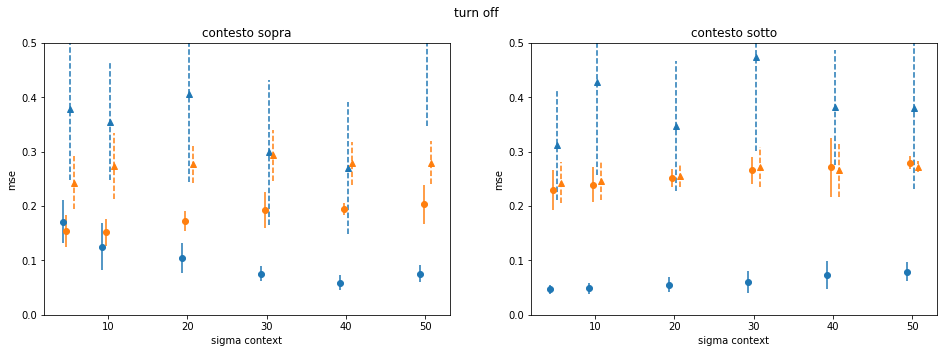

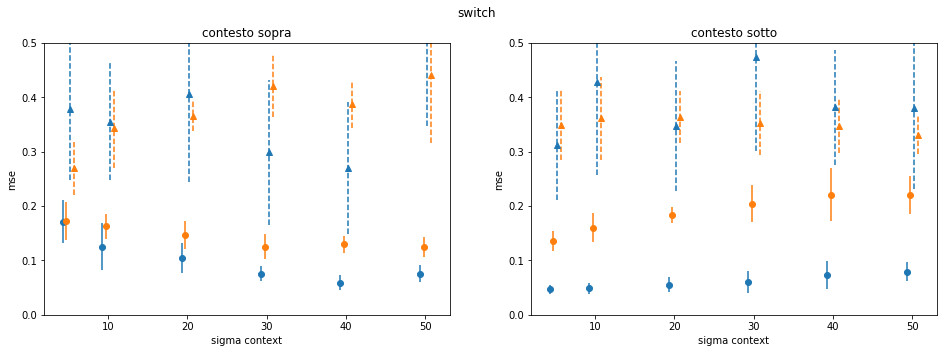

In [21]:
dd = 0.5

# context turn off

plt.figure(figsize=(16,5))
plt.suptitle('turn off')

plt.subplot(121)
plt.title('contesto sopra')
ddict = dict_contesto_apicale_turnoff
plt.xlabel('sigma context')
plt.ylabel('mse')
plt.ylim([0,0.5])
for x in [5,10,20,30,40,50]:
    y = [ddict[x][i][0] for i in range(len(ddict[x]))]
    eb1 = plt.errorbar(x-1.5*dd, np.mean(y), np.std(y), marker='o', color='C0')
    y = [ddict[x][i][1] for i in range(len(ddict[x]))]
    eb2 = plt.errorbar(x-0.5*dd, np.mean(y), np.std(y), marker='o', color='C1')
    y = [ddict[x][i][2] for i in range(len(ddict[x]))]
    eb3 = plt.errorbar(x+0.5*dd, np.mean(y), np.std(y), marker='^', color='C0')
    y = [ddict[x][i][3] for i in range(len(ddict[x]))]
    eb4 = plt.errorbar(x+1.5*dd, np.mean(y), np.std(y), marker='^', color='C1')
    eb3[-1][0].set_linestyle('--')
    eb4[-1][0].set_linestyle('--')

plt.subplot(122)
plt.title('contesto sotto')
ddict = dict_contesto_basale_turnoff
plt.xlabel('sigma context')
plt.ylabel('mse')
plt.ylim([0,0.5])
for x in [5,10,20,30,40,50]:
    y = [ddict[x][i][0] for i in range(len(ddict[x]))]
    eb1 = plt.errorbar(x-1.5*dd, np.mean(y), np.std(y), marker='o', color='C0')
    y = [ddict[x][i][1] for i in range(len(ddict[x]))]
    eb2 = plt.errorbar(x-0.5*dd, np.mean(y), np.std(y), marker='o', color='C1')
    y = [ddict[x][i][2] for i in range(len(ddict[x]))]
    eb3 = plt.errorbar(x+0.5*dd, np.mean(y), np.std(y), marker='^', color='C0')
    y = [ddict[x][i][3] for i in range(len(ddict[x]))]
    eb4 = plt.errorbar(x+1.5*dd, np.mean(y), np.std(y), marker='^', color='C1')
    eb3[-1][0].set_linestyle('--')
    eb4[-1][0].set_linestyle('--')

plt.show()

# context switch

plt.figure(figsize=(16,5))
plt.suptitle('switch')

plt.subplot(121)
plt.title('contesto sopra')
ddict = dict_contesto_apicale_switch
plt.xlabel('sigma context')
plt.ylabel('mse')
plt.ylim([0,0.5])
for x in [5,10,20,30,40,50]:
    y = [ddict[x][i][0] for i in range(len(ddict[x]))]
    eb1 = plt.errorbar(x-1.5*dd, np.mean(y), np.std(y), marker='o', color='C0')
    y = [ddict[x][i][1] for i in range(len(ddict[x]))]
    eb2 = plt.errorbar(x-0.5*dd, np.mean(y), np.std(y), marker='o', color='C1')
    y = [ddict[x][i][2] for i in range(len(ddict[x]))]
    eb3 = plt.errorbar(x+0.5*dd, np.mean(y), np.std(y), marker='^', color='C0')
    y = [ddict[x][i][3] for i in range(len(ddict[x]))]
    eb4 = plt.errorbar(x+1.5*dd, np.mean(y), np.std(y), marker='^', color='C1')
    eb3[-1][0].set_linestyle('--')
    eb4[-1][0].set_linestyle('--')

plt.subplot(122)
plt.title('contesto sotto')
ddict = dict_contesto_basale_switch
plt.xlabel('sigma context')
plt.ylabel('mse')
plt.ylim([0,0.5])
for x in [5,10,20,30,40,50]:
    y = [ddict[x][i][0] for i in range(len(ddict[x]))]
    eb1 = plt.errorbar(x-1.5*dd, np.mean(y), np.std(y), marker='o', color='C0')
    y = [ddict[x][i][1] for i in range(len(ddict[x]))]
    eb2 = plt.errorbar(x-0.5*dd, np.mean(y), np.std(y), marker='o', color='C1')
    y = [ddict[x][i][2] for i in range(len(ddict[x]))]
    eb3 = plt.errorbar(x+0.5*dd, np.mean(y), np.std(y), marker='^', color='C0')
    y = [ddict[x][i][3] for i in range(len(ddict[x]))]
    eb4 = plt.errorbar(x+1.5*dd, np.mean(y), np.std(y), marker='^', color='C1')
    eb3[-1][0].set_linestyle('--')
    eb4[-1][0].set_linestyle('--')

plt.show()

In [22]:
par['sigma_apical_context'] = 0
par['sigma_basal_context'] = 40

for n_trial in range(5):
    
    print('### n. trial = %d ###' % n_trial)
    print()
    
    # reload the module, in case it has been updated/changed since last loading
    print(reload(lttb_module))
    print()

    # Here we init our (recurrent) agent
    lttb = lttb_module.LTTB (par)

    init_clock_targ()
    training_rec(print_err=False)

    context_experiment(exp_type='turn_off_context', t_sw=250, show_plots=False)
    context_experiment(exp_type='switch_context', t_sw=250, show_plots=False)

### n. trial = 0 ###

<module 'lttb_contesto_both' from '/Users/cosimo/GitHub/LTTB/lttb_contesto_both.py'>

Training...


KeyboardInterrupt: 

In [373]:
par['sigma_apical_context'] = 50
par['sigma_basal_context'] = 0

for n_trial in range(1):
    
    print('### n. trial = %d ###' % n_trial)
    print()
    
    # reload the module, in case it has been updated/changed since last loading
    print(reload(lttb_module))
    print()

    # Here we init our (recurrent) agent
    lttb = lttb_module.LTTB (par)
    
    # Train
    init_clock_targ()
    training_rec(print_err=False)
    
    # Test
    cont_index = 0
    lttb.cont = lttb.cont*0
    
    lttb.y_targ = lttb.y_targ_collection[cont_index]
    lttb.initialize(par)
    
    apicalFactor = 0
    
    for t in range(lttb.T-2):
        
        lttb.step(apicalFactor = apicalFactor)
    
    SR = lttb.S_filtRO[:,1:-2]
    #SR = lttb.B_filt_rec[:,1:-2]
    Y = lttb.Jout@SR
    
    mse_rec = np.std(lttb.y_targ[:,1:-2] - Y)**2
    print('  mse=%.3f' % mse_rec)

### n. trial = 0 ###

<module 'lttb_contesto_both' from '/Users/cosimo/GitHub/LTTB/lttb_contesto_both.py'>

Training...
...done.
  mse=0.149


In [374]:
M1 = [lttb.S_soma[i][j] if lttb.S_wind[i][j]==0 else 0 for i in range(len(lttb.S_soma)) for j in range(len(lttb.S_soma[i]))]
M2 = [lttb.S_soma[i][j] if lttb.S_wind[i][j]>0 else 0 for i in range(len(lttb.S_soma)) for j in range(len(lttb.S_soma[i]))]
M1 = np.array(M1).reshape(np.shape(lttb.S_soma))
M2 = np.array(M2).reshape(np.shape(lttb.S_soma))

v1 = []
v2 = []
for i in range(np.shape(lttb.S_soma)[0]):
    for j in range(np.shape(lttb.S_soma)[1]):
        if(M1[i][j]>0):
            v1.append(i)
            v2.append(j)

w1 = []
w2 = []
for i in range(np.shape(lttb.S_soma)[0]):
    for j in range(np.shape(lttb.S_soma)[1]):
        if(M2[i][j]>0):
            w1.append(i)
            w2.append(j)

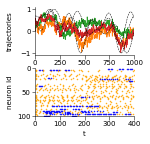

In [375]:
fs = 7
final_dpi = 500

cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5*cm, 5*cm))

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=fs, pad=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)

ax = axes[0]
for d in range(3):
    ax.plot(np.array(Y)[d].T, zorder=0, color='C' + str(d+1), lw=0.75)
for d in range(3):
    ax.plot(np.array(lttb.y_targ)[d].T, zorder=1, ls='--', color='black', lw=0.5)
ax.set_ylabel('', fontsize=fs)
#ax.xaxis.set_ticklabels([])
ax.set_xlim([0,1000])
ax.text(-0.25, 0.5, 'trajectories', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

ax = axes[1]
#ax.imshow(B_filt[0:401,:len(POSITION)+2], zorder=1, aspect='auto')
#ax.imshow(1-(S_soma[:,0:len(POSITION)])*(0.5+S_wind[:,0:len(POSITION)]), aspect='auto', cmap='magma')
cmap1 = matplotlib.colors.ListedColormap(['None','orange'], name='colors', N=None)
cmap2 = matplotlib.colors.ListedColormap(['None','blue'], name='colors', N=None)
#ax.imshow(M1[0:101,:250], cmap=cmap1, aspect='auto', vmin=0, vmax=1)
#ax.imshow(M2[0:101,:250], cmap=cmap2, aspect='auto', vmin=0, vmax=1)
for i in range(len(v1)):
    if(v1[i]>2 and v1[i]<99 and v2[i]>2 and v2[i]<399):
        y = v1[i]
        ax.scatter(v2[i], y, color='orange', marker='.', s=1)
for i in range(len(w1)):
    if(w1[i]>1 and w1[i]<100 and w2[i]>2 and w2[i]<399):
        y = w1[i]
        ax.scatter(w2[i], y, color='blue', marker='.', s=1)
ax.set_xlabel('t', fontsize=fs)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,400])
ax.set_ylim([100,0])
ax.set_yticks([100,50,0])
ax.text(-0.25, 0.5, 'neuron id', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

plt.tight_layout()
plt.subplots_adjust(left=0.23, bottom=0.18, right=0.93, top=0.95, wspace=None, hspace=0.275)
fig_title = 'fig_3D'
#plt.savefig('./' + fig_title + '.eps', dpi=final_dpi)
#plt.savefig('./' + fig_title + '.pdf', dpi=final_dpi)
plt.show()

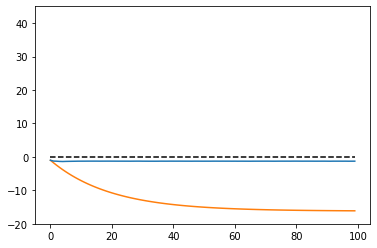

In [29]:
n=13
y = [_ if _<0 else 40 for _ in lttb.Vsoma[n][0:100]]
plt.plot(y, color='C1')
#plt.plot(lttb.Vapic[n][0:100], color='C2')
y = [_ if _<0 else 40 for _ in lttb.VapicRec[n][0:100]]
plt.plot(y, color='C0')
#plt.plot(lttb.S_soma[n][0:100])
#plt.plot(lttb.VapicRec[4])
plt.ylim([-20,45])
plt.plot(range(100),[0]*100,ls='--',color='black')
plt.show()

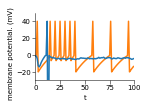

In [190]:
fs = 7
final_dpi = 500

cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5*cm, 3.5*cm))

ax = axes

#for ax in axes:
if(True):
    ax.tick_params(axis='both', which='major', labelsize=fs, pad=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)


n=32
y = [_ if _<0 else 40 for _ in lttb.Vsoma[n][0:100]]
ax.plot(y, color='C1')
y = [_ if _<0 else 40 for _ in lttb.VapicRec[n][0:100]]
ax.plot(y, color='C0')
ax.set_xlabel('t', fontsize=fs)
ax.set_ylabel('', fontsize=fs)
#ax.xaxis.set_ticklabels([])
ax.set_xlim([0,100])
ax.set_ylim([-30,50])
ax.text(-0.25, 0.4, 'membrane potential. (mV)', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

plt.tight_layout()
plt.subplots_adjust(left=0.23, bottom=0.25, right=0.93, top=0.93, wspace=None, hspace=0.275)
plt.savefig('./fig_3D_mV.eps', dpi=final_dpi)
plt.savefig('./fig_3D_mV.pdf', dpi=final_dpi)
plt.show()

In [67]:
np.shape(M1)

(500, 1000)

In [69]:
v1 = []
v2 = []
for i in range(500):
    for j in range(1000):
        if(M1[i][j]>0):
            v1.append(i)
            v2.append(j)

w1 = []
w2 = []
for i in range(500):
    for j in range(1000):
        if(M2[i][j]>0):
            w1.append(i)
            w2.append(j)

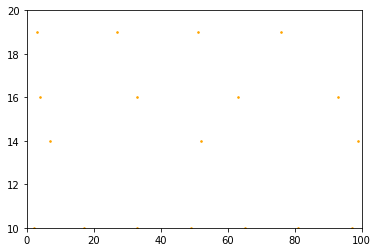

In [28]:
plt.scatter(v2,v1,color='orange',marker='.',s=10)
plt.scatter(w2,w1,color='blue',marker='.',s=10)
plt.xlim([0,100])
plt.ylim([10,20])
plt.show()

In [34]:
def run_many_trials():
    
    MSE = np.zeros((n_contexts,n_contexts))
    
    for cont_index_i in range(n_contexts):
        for cont_index in range(n_contexts):

            context = []
    
            lttb.cont = lttb.cont*0
            lttb.cont[cont_index_i] = 1

            lttb.y_targ = lttb.y_targ_collection[cont_index]

            lttb.initialize(par)

            #run simulation

            apicalFactor = 0

            for t in range(lttb.T-2):

                if t==200:
                    apicalFactor = 0
                    #lttb.cont = lttb.cont*0.1
                    #lttb.cont[0] = 1
                context.append(lttb.cont)

                lttb.step(apicalFactor = apicalFactor)

            SR = lttb.S_filtRO[:,1:-2]#lttb.B_filt_rec[:,1:-2]#
            Y = lttb.Jout@SR
            mse_rec_train = np.std(lttb.y_targ[:,1:-3] - Y[:,0:-1])**2

            #print(mse_rec_train)
            MSE[cont_index_i,cont_index] = mse_rec_train

        #mse, Y = lttb.train_ro(par,out_epochs = 1)
            
            """
            plt.figure(figsize=(12, 4))
            plt.subplot(211)
            plt.plot(Y.T)
            plt.plot(lttb.y_targ.T,'--')
            plt.plot(np.array(context),'--')

            plt.xlabel('time(s)')
            plt.ylabel('$y_{targ}$ --- $y_{out}$')
            plt.subplot(212)
            plt.imshow(lttb.S_filtRO[0:20,:],aspect='auto')

            #plt.subplot(313)
            #plt.imshow(lttb.S_wind[0:20,:],aspect='auto')

            plt.show()
            """
    return MSE

#run_many_trials()

In [7]:
plt.imshow(MSE)
plt.colorbar()
plt.xlabel('trajectory')
plt.ylabel('context')

NameError: name 'MSE' is not defined

In [10]:
n_contexts = 3
par['n_contexts'] = n_contexts

#sigma_context_values = [25, 50, 75, 100, 200, 300, 400, 500, 600]
#MSE_matrices = []
#onDiag_aver = []
#offDiag_aver = []

for sigma_context in [700,800]:
    
    print('sigma_context = ' + str(sigma_context))
    par['sigma_context'] = sigma_context
    
    lttb = LTTB (par)
    init_clock_targ()
    training_rec()
    MSE = run_many_trials()
    
    MSE_matrices.append(MSE)
    
    onDiag_aver.append(np.mean([MSE[i][i] for i in range(n_contexts)]))
    offDiag_aver.append(np.mean([MSE[i][j] for i in range(n_contexts) for j in range(n_contexts) if i!=j]))
    
    if(False):
        plt.imshow(MSE)
        plt.colorbar()
        plt.xlabel('trajectory')
        plt.ylabel('context')
        plt.show()

sigma_context = 700
sigma_context = 800


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


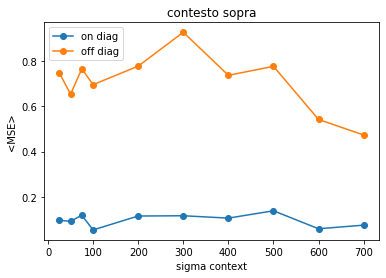

In [22]:
plt.plot(sigma_context_values, onDiag_aver, marker='o', label='on diag')
plt.plot(sigma_context_values, offDiag_aver, marker='o', label='off diag')
plt.xlabel('sigma context')
plt.ylabel('<MSE>')
plt.legend(loc='upper left')
plt.title('contesto sopra')
plt.show()

In [90]:
prova_10L = [sigma_context_values, MSE_matrices, onDiag_aver, offDiag_aver]

In [19]:
# prova_1 = [sigma_context_values, MSE_matrices, onDiag_aver, offDiag_aver]

In [23]:
# prova_2 = [sigma_context_values, MSE_matrices, onDiag_aver, offDiag_aver]

In [28]:
# prova_3 = [sigma_context_values, MSE_matrices, onDiag_aver, offDiag_aver]

In [36]:
# prova_4 = [sigma_context_values, MSE_matrices, onDiag_aver, offDiag_aver]

In [44]:
# prova_5 = [sigma_context_values, MSE_matrices, onDiag_aver, offDiag_aver]

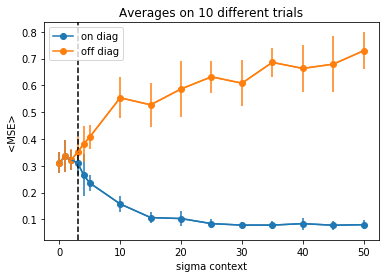

In [91]:
#provas = [prova_1, prova_2, prova_3, prova_4, prova_5]
provas = [prova_1L, prova_2L, prova_3L, prova_4L, prova_5L, prova_6L, prova_7L, prova_8L, prova_9L, prova_10L]

onDiag_aver_mean = []
offDiag_aver_mean = []
onDiag_aver_std = []
offDiag_aver_std = []

for i in range(len(sigma_context_values)):
    onDiag_aver_mean.append( np.mean( [prova[2][i] for prova in provas] ) )
    offDiag_aver_mean.append( np.mean( [prova[3][i] for prova in provas] ) )
    onDiag_aver_std.append( np.std( [prova[2][i] for prova in provas] ) )
    offDiag_aver_std.append( np.std( [prova[3][i] for prova in provas] ) )

plt.plot(sigma_context_values, onDiag_aver_mean, marker='o', label='on diag', color='C0')
plt.errorbar(sigma_context_values, onDiag_aver_mean, onDiag_aver_std, label=None, color='C0')
plt.plot(sigma_context_values, offDiag_aver_mean, marker='o', label='off diag', color='C1')
plt.errorbar(sigma_context_values, offDiag_aver_mean, offDiag_aver_std, label=None, color='C1')
plt.title('Averages on ' + str(len(provas)) + ' different trials')
plt.xlabel('sigma context')
plt.ylabel('<MSE>')
plt.legend(loc='upper left')
y_min,y_max = plt.gca().get_ylim()
plt.ylim([y_min,y_max])
plt.plot([3,3], [y_min,y_max], ls='--', color='black')
plt.show()

n = 0
  sigma_context = 0
  sigma_context = 0.5
  sigma_context = 1
  sigma_context = 2
  sigma_context = 3
  sigma_context = 4
  sigma_context = 5
  sigma_context = 7.5
  sigma_context = 10
  sigma_context = 20
  sigma_context = 30
  sigma_context = 40
  sigma_context = 50
  sigma_context = 75
  sigma_context = 100


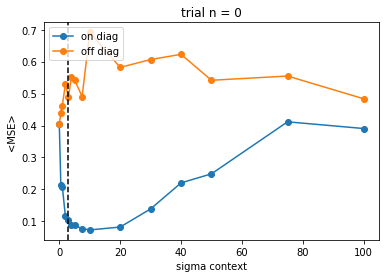

n = 1
  sigma_context = 0
  sigma_context = 0.5
  sigma_context = 1
  sigma_context = 2
  sigma_context = 3
  sigma_context = 4
  sigma_context = 5
  sigma_context = 7.5
  sigma_context = 10
  sigma_context = 20
  sigma_context = 30
  sigma_context = 40
  sigma_context = 50
  sigma_context = 75
  sigma_context = 100


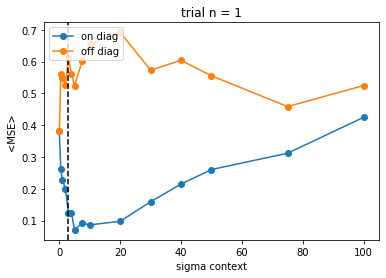

n = 2
  sigma_context = 0
  sigma_context = 0.5
  sigma_context = 1
  sigma_context = 2
  sigma_context = 3
  sigma_context = 4
  sigma_context = 5
  sigma_context = 7.5
  sigma_context = 10
  sigma_context = 20
  sigma_context = 30
  sigma_context = 40
  sigma_context = 50
  sigma_context = 75
  sigma_context = 100


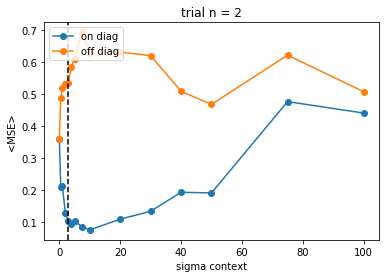

n = 3
  sigma_context = 0
  sigma_context = 0.5
  sigma_context = 1
  sigma_context = 2
  sigma_context = 3
  sigma_context = 4
  sigma_context = 5
  sigma_context = 7.5
  sigma_context = 10
  sigma_context = 20
  sigma_context = 30
  sigma_context = 40
  sigma_context = 50
  sigma_context = 75
  sigma_context = 100


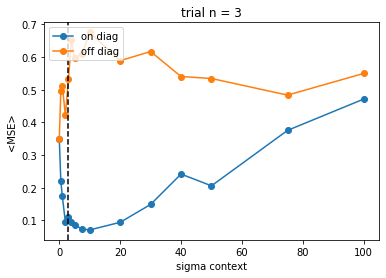

n = 4
  sigma_context = 0
  sigma_context = 0.5
  sigma_context = 1
  sigma_context = 2
  sigma_context = 3
  sigma_context = 4
  sigma_context = 5
  sigma_context = 7.5
  sigma_context = 10
  sigma_context = 20
  sigma_context = 30
  sigma_context = 40
  sigma_context = 50
  sigma_context = 75
  sigma_context = 100


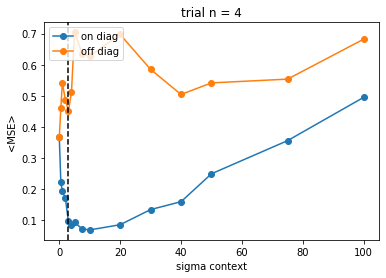

n = 5
  sigma_context = 0
  sigma_context = 0.5
  sigma_context = 1
  sigma_context = 2
  sigma_context = 3
  sigma_context = 4
  sigma_context = 5
  sigma_context = 7.5
  sigma_context = 10
  sigma_context = 20
  sigma_context = 30
  sigma_context = 40
  sigma_context = 50
  sigma_context = 75
  sigma_context = 100


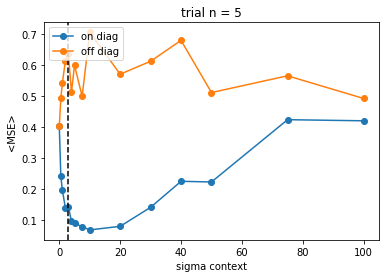

n = 6
  sigma_context = 0
  sigma_context = 0.5
  sigma_context = 1
  sigma_context = 2
  sigma_context = 3
  sigma_context = 4
  sigma_context = 5
  sigma_context = 7.5
  sigma_context = 10
  sigma_context = 20
  sigma_context = 30
  sigma_context = 40
  sigma_context = 50
  sigma_context = 75
  sigma_context = 100


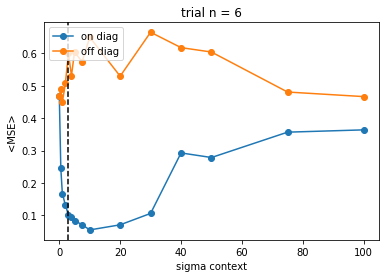

n = 7
  sigma_context = 0
  sigma_context = 0.5
  sigma_context = 1
  sigma_context = 2
  sigma_context = 3
  sigma_context = 4
  sigma_context = 5
  sigma_context = 7.5
  sigma_context = 10
  sigma_context = 20
  sigma_context = 30
  sigma_context = 40
  sigma_context = 50
  sigma_context = 75
  sigma_context = 100


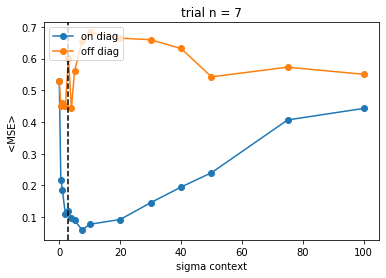

n = 8
  sigma_context = 0
  sigma_context = 0.5
  sigma_context = 1
  sigma_context = 2
  sigma_context = 3
  sigma_context = 4
  sigma_context = 5
  sigma_context = 7.5
  sigma_context = 10
  sigma_context = 20
  sigma_context = 30
  sigma_context = 40
  sigma_context = 50
  sigma_context = 75
  sigma_context = 100


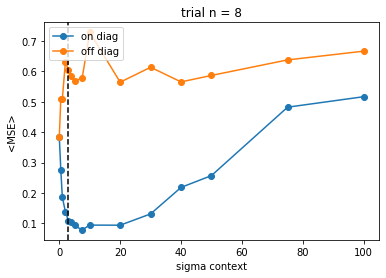

n = 9
  sigma_context = 0
  sigma_context = 0.5
  sigma_context = 1
  sigma_context = 2
  sigma_context = 3
  sigma_context = 4
  sigma_context = 5
  sigma_context = 7.5
  sigma_context = 10
  sigma_context = 20
  sigma_context = 30
  sigma_context = 40
  sigma_context = 50
  sigma_context = 75
  sigma_context = 100


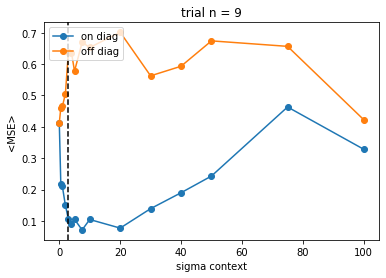

In [13]:
n_contexts = 5
par['n_contexts'] = n_contexts
sigma_context_values = [0, 0.5, 1, 2, 3, 4, 5, 7.5, 10, 20, 30, 40, 50, 75, 100]
provas = []

for n in range(10):
    
    print('n = ' + str(n))
    
    MSE_matrices = []
    onDiag_aver = []
    offDiag_aver = []
    
    for sigma_context in sigma_context_values:
        
        print('  sigma_context = ' + str(sigma_context))
        par['sigma_context'] = sigma_context
        
        lttb = LTTB (par)
        init_clock_targ()
        training_rec()
        MSE = run_many_trials()
        
        MSE_matrices.append(MSE)
        
        onDiag_aver.append(np.mean([MSE[i][i] for i in range(n_contexts)]))
        offDiag_aver.append(np.mean([MSE[i][j] for i in range(n_contexts) for j in range(n_contexts) if i!=j]))
        
        if(False):
            plt.imshow(MSE)
            plt.colorbar()
            plt.xlabel('trajectory')
            plt.ylabel('context')
            plt.show()
            
    if(True):
        plt.plot(sigma_context_values, onDiag_aver, marker='o', label='on diag', color='C0')
        plt.plot(sigma_context_values, offDiag_aver, marker='o', label='off diag', color='C1')
        plt.title('trial n = ' + str(n))
        plt.xlabel('sigma context')
        plt.ylabel('<MSE>')
        plt.legend(loc='upper left')
        y_min,y_max = plt.gca().get_ylim()
        plt.ylim([y_min,y_max])
        plt.plot([3,3], [y_min,y_max], ls='--', color='black')
        plt.show()
        
    provas.append([sigma_context_values, MSE_matrices, onDiag_aver, offDiag_aver])

provas_n5 = provas

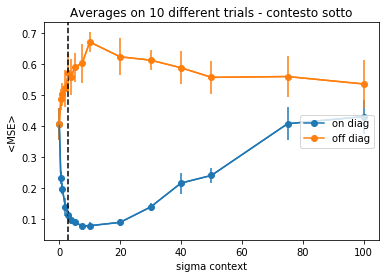

In [15]:
provas = provas_n5
onDiag_aver_mean = []
offDiag_aver_mean = []
onDiag_aver_std = []
offDiag_aver_std = []

for i in range(len(sigma_context_values)):
    onDiag_aver_mean.append( np.mean( [prova[2][i] for prova in provas] ) )
    offDiag_aver_mean.append( np.mean( [prova[3][i] for prova in provas] ) )
    onDiag_aver_std.append( np.std( [prova[2][i] for prova in provas] ) )
    offDiag_aver_std.append( np.std( [prova[3][i] for prova in provas] ) )

plt.plot(sigma_context_values, onDiag_aver_mean, marker='o', label='on diag', color='C0')
plt.errorbar(sigma_context_values, onDiag_aver_mean, onDiag_aver_std, label=None, color='C0')
plt.plot(sigma_context_values, offDiag_aver_mean, marker='o', label='off diag', color='C1')
plt.errorbar(sigma_context_values, offDiag_aver_mean, offDiag_aver_std, label=None, color='C1')
plt.title('Averages on ' + str(len(provas)) + ' different trials - contesto sotto')
plt.xlabel('sigma context')
plt.ylabel('<MSE>')
plt.legend(loc='center right')
y_min,y_max = plt.gca().get_ylim()
plt.ylim([y_min,y_max])
plt.plot([3,3], [y_min,y_max], ls='--', color='black')
plt.show()

In [223]:
cont = ["distal","basal"][1]
n_trial = 1

df = pd.read_csv('/Users/cosimo/GitHub/LTTB/' + cont + '_trial_%03d.csv' % n_trial, sep=';')

N = 7

M_on = [[0. for i in range(N)] for i in range(N)]
M_off = [[0. for i in range(N)] for i in range(N)]
for r,row in df.iterrows():
    i = int(r/N)
    j = r%N
    M_on[i][j] = row['onDiag_aver_MSE']
    M_off[i][j] = row['offDiag_aver_MSE']

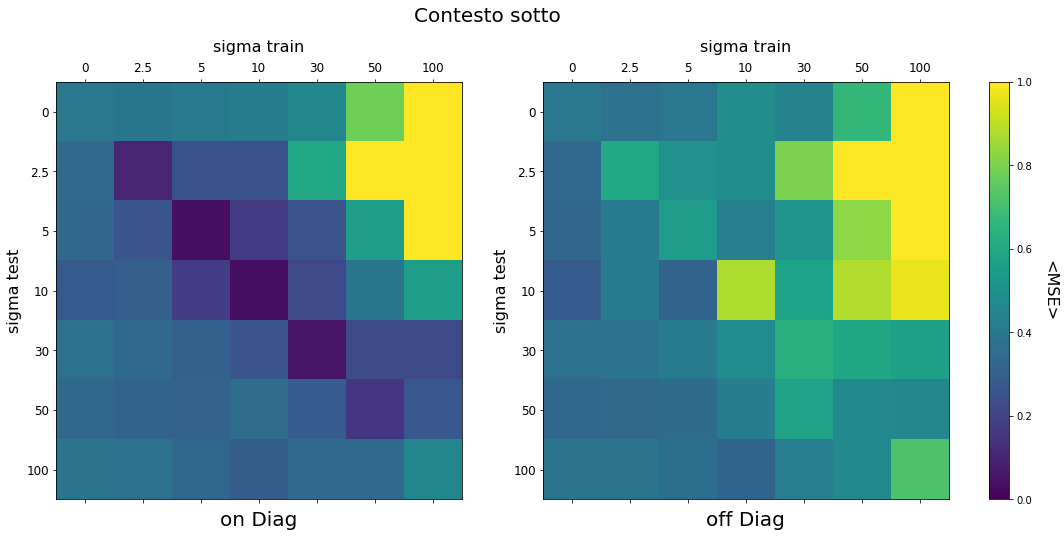

In [224]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize = (16,8))

if(cont=="distal"):
    plt.suptitle('Contesto sopra', fontsize=20)
elif(cont=="basal"):
    plt.suptitle('Contesto sotto', fontsize=20)

#axes.text(0.5, 0.9, '?', color='black', ha='center', va='center', fontsize=20, transform=axes.transAxes)

ax = axes[0]
ax.matshow(M_on, vmin=0, vmax=1, aspect='auto')
ax.set_xticks(range(N))
ax.set_xticklabels([0, 2.5, 5, 10, 30, 50, 100], fontsize=12)
ax.set_xlim([-0.5,N-0.5])
ax.set_xlabel('sigma train', labelpad=10, fontsize=16)
ax.xaxis.set_label_position("top")
ax.set_yticks(range(N))
ax.set_yticklabels([0, 2.5, 5, 10, 30, 50, 100], fontsize=12)
ax.set_ylim([N-0.5,-0.5])
ax.set_ylabel('sigma test', fontsize=16)
ax.text(0.5, -0.05, 'on Diag', color='black', ha='center', va='center', fontsize=20, transform=ax.transAxes)

ax = axes[1]
im = ax.matshow(M_off, vmin=0, vmax=1, aspect='auto')
ax.set_xticks(range(N))
ax.set_xticklabels([0, 2.5, 5, 10, 30, 50, 100], fontsize=12)
ax.set_xlim([-0.5,N-0.5])
ax.set_xlabel('sigma train', labelpad=10, fontsize=16)
ax.xaxis.set_label_position("top")
ax.set_yticks(range(N))
ax.set_yticklabels([0, 2.5, 5, 10, 30, 50, 100], fontsize=12)
ax.set_ylim([N-0.5,-0.5])
ax.set_ylabel('sigma test', fontsize=16)
ax.text(0.5, -0.05, 'off Diag', color='black', ha='center', va='center', fontsize=20, transform=ax.transAxes)

axins = inset_axes(ax, width="5%", height="100%", bbox_to_anchor=(1.10, 0.00, 1, 1), bbox_transform=ax.transAxes, loc=3, borderpad=0)
cbar = fig.colorbar(im, cax=axins, ticks=[0,0.2,0.4,0.6,0.8,1])
cbar.set_label('<MSE>', rotation=270, fontsize=16, labelpad=25)

fig.subplots_adjust(top=0.85)
plt.show()

In [31]:
cont = ["distal","basal"][0]
N = 7

M_on_aver = [[0. for i in range(N)] for i in range(N)]
M_off_aver = [[0. for i in range(N)] for i in range(N)]

for n_trial in range(1,6):
    
    df = pd.read_csv('/Users/cosimo/GitHub/LTTB/' + cont + '_trial_%03d.csv' % n_trial, sep=';')
    
    M_on = [[0. for i in range(N)] for i in range(N)]
    M_off = [[0. for i in range(N)] for i in range(N)]
    for r,row in df.iterrows():
        i = int(r/N)
        j = r%N
        M_on[i][j] = row['onDiag_aver_MSE']
        M_off[i][j] = row['offDiag_aver_MSE']
        M_on_aver[i][j] += M_on[i][j]
        M_off_aver[i][j] += M_off[i][j]

for i in range(N):
    for j in range(N):
        M_on_aver[i][j] /= N
        M_off_aver[i][j] /= N

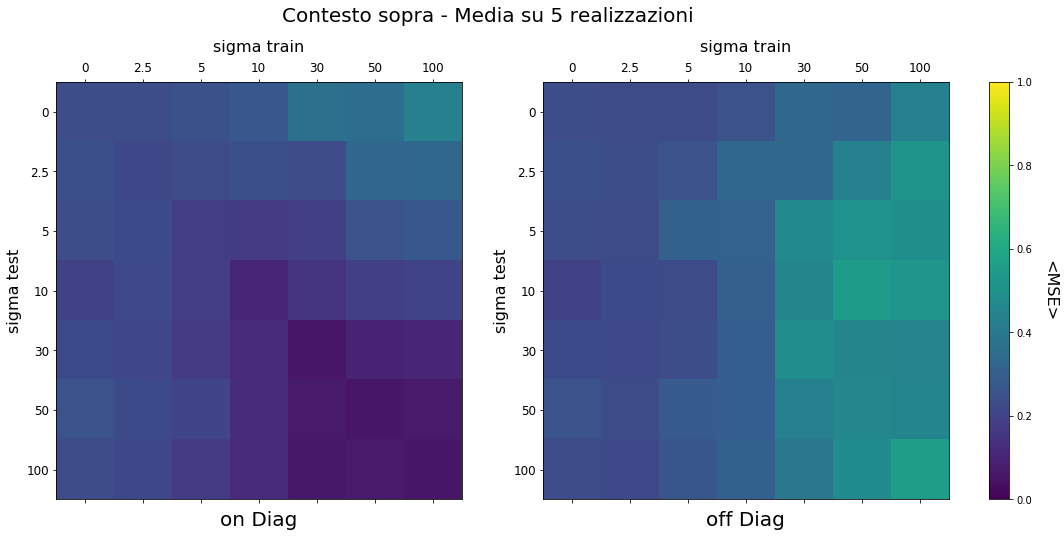

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize = (16,8))

if(cont=="distal"):
    plt.suptitle('Contesto sopra - Media su 5 realizzazioni', fontsize=20)
elif(cont=="basal"):
    plt.suptitle('Contesto sotto - Media su 5 realizzazioni', fontsize=20)

#axes.text(0.5, 0.9, '?', color='black', ha='center', va='center', fontsize=20, transform=axes.transAxes)

ax = axes[0]
ax.matshow(M_on_aver, vmin=0, vmax=1, aspect='auto')
ax.set_xticks(range(N))
ax.set_xticklabels([0, 2.5, 5, 10, 30, 50, 100], fontsize=12)
ax.set_xlim([-0.5,N-0.5])
ax.set_xlabel('sigma train', labelpad=10, fontsize=16)
ax.xaxis.set_label_position("top")
ax.set_yticks(range(N))
ax.set_yticklabels([0, 2.5, 5, 10, 30, 50, 100], fontsize=12)
ax.set_ylim([N-0.5,-0.5])
ax.set_ylabel('sigma test', fontsize=16)
ax.text(0.5, -0.05, 'on Diag', color='black', ha='center', va='center', fontsize=20, transform=ax.transAxes)

ax = axes[1]
im = ax.matshow(M_off_aver, vmin=0, vmax=1, aspect='auto')
ax.set_xticks(range(N))
ax.set_xticklabels([0, 2.5, 5, 10, 30, 50, 100], fontsize=12)
ax.set_xlim([-0.5,N-0.5])
ax.set_xlabel('sigma train', labelpad=10, fontsize=16)
ax.xaxis.set_label_position("top")
ax.set_yticks(range(N))
ax.set_yticklabels([0, 2.5, 5, 10, 30, 50, 100], fontsize=12)
ax.set_ylim([N-0.5,-0.5])
ax.set_ylabel('sigma test', fontsize=16)
ax.text(0.5, -0.05, 'off Diag', color='black', ha='center', va='center', fontsize=20, transform=ax.transAxes)

axins = inset_axes(ax, width="5%", height="100%", bbox_to_anchor=(1.10, 0.00, 1, 1), bbox_transform=ax.transAxes, loc=3, borderpad=0)
cbar = fig.colorbar(im, cax=axins, ticks=[0,0.2,0.4,0.6,0.8,1])
cbar.set_label('<MSE>', rotation=270, fontsize=16, labelpad=25)

fig.subplots_adjust(top=0.85)
plt.show()

## blocking the context at some point

In [30]:
init_clock_targ()
training_rec()

Training...
t=0
  0.2833168617254629
t=5
  0.20387844611032138
t=10
  0.17062071262823214
t=15
  0.14065282156555992
t=20
  0.1406298681112204
t=25
  0.14049307561725283
t=30
  0.09488451781511241
t=35
  0.09978457211559441
t=40
  0.09357843370265438
t=45
  0.09326138819258131
t=50
  0.0869481087877882
t=55
  0.0748278980641874
t=60
  0.09741720630964411
t=65
  0.07667106029375181
t=70
  0.09089808434383112
t=75
  0.08317180853140356
t=80
  0.066947237006334
t=85
  0.07605893817954433
t=90
  0.08022128534260646
t=95
  0.06349028696241431



0.22282672703714038


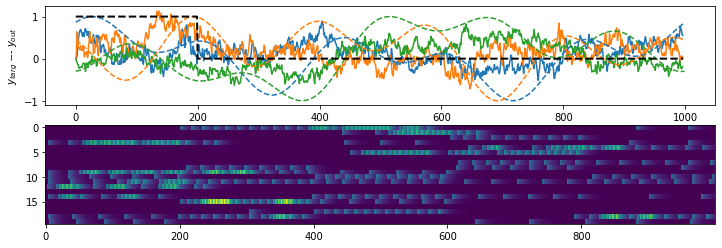

0.13909721498275524


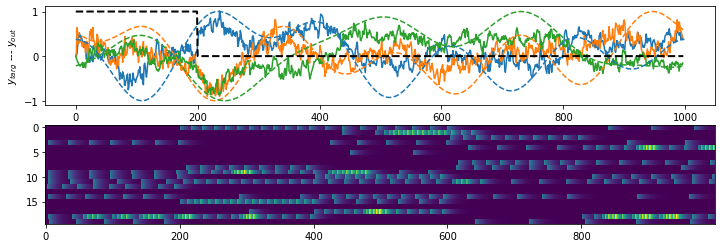

In [73]:
for cont_index in range(n_contexts):
    
    context = []

    lttb.cont = lttb.cont*0
    lttb.cont[cont_index] = 1

    lttb.y_targ = lttb.y_targ_collection[cont_index]

    lttb.initialize(par)

    #run simulation
    
    apicalFactor = 0

    for t in range(lttb.T-2):
 
        if t==200:
            apicalFactor = 0
            #lttb.cont = lttb.cont*0.1
            #lttb.cont[0] = 1
            lttb.cont[cont_index] = 0
        context.append(lttb.cont[cont_index])
        
        lttb.step(apicalFactor = apicalFactor)

    SR = lttb.S_filtRO[:,1:-2]#lttb.B_filt_rec[:,1:-2]#
    Y = lttb.Jout@SR
    mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

    print(mse_rec_train)
    
#mse, Y = lttb.train_ro(par,out_epochs = 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(211)
    for i in range(len(Y)):
        plt.plot(Y[i].T, color='C'+str(i))
    for i in range(len(Y)):
        plt.plot(lttb.y_targ[i].T, '--', color='C'+str(i))
    plt.plot(np.array(context),'--', color='black', lw=2)
    
    plt.xlabel('time(s)')
    plt.ylabel('$y_{targ}$ --- $y_{out}$')
    plt.subplot(212)
    plt.imshow(lttb.S_filtRO[0:20,:],aspect='auto')
    
    #plt.subplot(313)
    #plt.imshow(lttb.S_wind[0:20,:],aspect='auto')
    
    plt.show()

In [69]:
len(Y)

3

In [38]:
lttb.cont

array([0., 0., 0.])

NameError: name 'lttb' is not defined

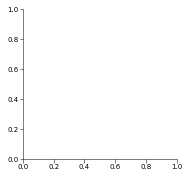

In [3]:
fs = 7
fig_x_size_cm = 7
fig_y_size_cm = 7

final_dpi = 250

cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(fig_x_size_cm*cm, fig_y_size_cm*cm))

ax = axes

#for ax in axes:
if(True):
    ax.tick_params(axis='both', which='major', labelsize=fs, pad=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)


n=32
y = [_ if _<0 else 40 for _ in lttb.Vsoma[n][0:100]]
ax.plot(y, color='C1')
y = [_ if _<0 else 40 for _ in lttb.VapicRec[n][0:100]]
ax.plot(y, color='C0')
ax.set_xlabel('t', fontsize=fs)
ax.set_ylabel('', fontsize=fs)
#ax.xaxis.set_ticklabels([])
ax.set_xlim([0,100])
ax.set_ylim([-30,50])
ax.text(-0.25, 0.4, 'membrane potential. (mV)', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

plt.tight_layout()
plt.subplots_adjust(left=0.23, bottom=0.25, right=0.93, top=0.93, wspace=None, hspace=0.275)
fig_title = 'paper_fig_2'
plt.savefig('./' + fig_title + '.eps', dpi=final_dpi)
plt.savefig('./' + fig_title + '.pdf', dpi=final_dpi)
plt.show()